In [1]:
!pip install -q -U keras-tuner

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

import numpy as np

SEED = 1103
tf.random.set_seed(SEED)
np.random.seed(SEED)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 958.3 kB/s eta 0:00:00


In [2]:
from pathlib import Path

df_path = Path('/content/drive/MyDrive/BACHELORS_PROJECT/data/processed/processed_func_data.csv')
models_path = Path('/content/drive/MyDrive/BACHELORS_PROJECT/models')

In [5]:
audio_model = keras.models.load_model(models_path / "audio_model.keras")
audio_logits_model = keras.models.load_model(models_path / "audio_logits_model.keras")

text_model = keras.models.load_model(models_path / "text_model.keras")
text_logits_model = keras.models.load_model(models_path / "text_logits_model.keras")

eta_model = keras.models.load_model(models_path / "eta_model.keras")
eta_logits_model = keras.models.load_model(models_path / "eta_logits_model.keras")

ita_model = keras.models.load_model(models_path / "ita_model.keras")
ita_logits_model = keras.models.load_model(models_path / "ita_logits_model.keras")

lta_model = keras.models.load_model(models_path / "lta_model.keras")
lta_logits_model = keras.models.load_model(models_path / "lta_logits_model.keras")

In [11]:
lta_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 988)]                0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 256)                  196864    ['input_3[0][0]']             
                                                                                                  
 dense_10 (Dense)            (None, 256)                  253184    ['input_4[0][0]']             
                                                                                            

# get data

In [12]:
def encode_labels(text_labels):
    """ One-hot encodes emotion labels. """

    #labels = ['neutral', 'joy', 'surprise', 'anger_disgust', 'fear_sadness']
    labels = ['neutral', 'joy', 'surprise', 'anger', 'disgust', 'fear', 'sadness']
    num_classes = len(labels)
    label_to_index = {label: index for index, label in enumerate(labels)}
    index_to_label = {index: label for index, label in enumerate(labels)}

    idx_labels = [label_to_index[label] for label in text_labels]
    onehot_labels = tf.one_hot(idx_labels, len(labels)).numpy()
    return onehot_labels


def get_labels(df):
    train_labels = df[df['split'] == 'train']['emotion']
    val_labels = df[df['split'] == 'val']['emotion']
    test_labels = df[df['split'] == 'test']['emotion']
    return train_labels, val_labels, test_labels

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


def do_scale(X, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        scaled_X = scaler.fit_transform(X)
        return scaled_X, scaler
    else:
        return scaler.transform(X)

def get_audio_features(df):
    ignore = ['filename', 'id', 'conversation_line', 'emotion', 'speaker', 'split']
    X_train_audio = np.array(df[df['split'] == 'train'].drop(columns=ignore).values.tolist())
    X_val_audio = np.array(df[df['split'] == 'val'].drop(columns=ignore).values.tolist())
    X_test_audio = np.array(df[df['split'] == 'test'].drop(columns=ignore).values.tolist())

    return X_train_audio, X_val_audio, X_test_audio


def get_audio(df):
    print('Audio')
    X_train_audio, X_val_audio, X_test_audio = get_audio_features(df)

    print('Scaling')
    X_train_audio, scaler = do_scale(X_train_audio)
    X_val_audio = do_scale(X_val_audio, scaler)
    X_test_audio = do_scale(X_test_audio, scaler)

    return X_train_audio, X_val_audio, X_test_audio


def get_text():
    print('Text')

    bert_train = np.load('/content/drive/MyDrive/BACHELORS_PROJECT/data/processed/bert_train_35.npy')
    bert_val = np.load('/content/drive/MyDrive/BACHELORS_PROJECT/data/processed/bert_val_35.npy')
    bert_test = np.load('/content/drive/MyDrive/BACHELORS_PROJECT/data/processed/bert_test_35.npy')

    return bert_train, bert_val, bert_test


def get_both(df):
    audio_train, audio_val, audio_test = get_audio(df)
    bert_train, bert_val, bert_test = get_text()
    return [bert_train, audio_train], [bert_val, audio_val], [bert_test, audio_test]


def get_data(fname, model_type=None):

    df = pd.read_csv(fname, dtype={'id':str})

    print('Labels')
    y_train, y_val, y_test = get_labels(df)

    if model_type=="AUDIO-ONLY":
      X_train, X_val, X_test = get_audio(df)
    elif model_type=="TEXT-ONLY":
      X_train, X_val, X_test = get_text()
    elif model_type=="TEXT-AUDIO":
      X_train, X_val, X_test = get_both(df)
    else:
      print("Invalid model type.")
      return

    y_train_onehot = encode_labels(y_train)
    y_val_onehot = encode_labels(y_val)
    y_test_onehot = encode_labels(y_test)

    return X_train, y_train_onehot, X_val, y_val_onehot, X_test, y_test_onehot



In [14]:
X_train_audio, y_train_onehot, X_val_audio, y_val_onehot, X_test_audio, y_test_onehot = get_data(fname=df_path, model_type="AUDIO-ONLY")

Labels
Audio
Scaling


In [15]:
X_train_text, y_train_onehot, X_val_text, y_val_onehot, X_test_text, y_test_onehot = get_data(fname=df_path, model_type="TEXT-ONLY")

Labels
Text


In [16]:
X_train_both, y_train_onehot, X_val_both, y_val_onehot, X_test_both, y_test_onehot = get_data(fname=df_path, model_type="TEXT-AUDIO")

Labels
Audio
Scaling
Text


# Helper functions/classes

## model building

In [4]:
from keras.layers import Input, Dense, Layer, Dropout
from keras import Model
import keras.backend as K

@keras.saving.register_keras_serializable()
class SamplingSoftmax(Layer):
    def __init__(self, num_samples=50):
        self.num_samples = num_samples
        super().__init__()

    def call(self, inputs):
      assert len(inputs) == 2
      logit_mean = inputs[0]
      logit_var = inputs[1]

      logit_mean = K.expand_dims(logit_mean, axis=1)
      logit_mean = K.repeat_elements(logit_mean, self.num_samples, axis=1)

      logit_var = K.expand_dims(logit_var, axis=1)
      logit_var = K.repeat_elements(logit_var, self.num_samples, axis=1)

      normal_samples = K.random_normal(K.shape(logit_mean))
      samples = normal_samples * logit_var + logit_mean
      softmaxed = K.softmax(samples)
      out = K.mean(softmaxed, axis=1)

      return out

    def get_config(self):
        return {"num_samples": self.num_samples}

## plotting

In [22]:
import matplotlib.pyplot as plt

def plot_history(history, model, metric='loss', loc='upper right'):
    plt.plot(history.history[metric], color='#A1DAC2')
    plt.plot(history.history['val_' + metric])
    plt.title(metric[0].upper() + metric[1:] + ' History for ' + model)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)
    plt.show()

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true_int, y_pred, model_name='?'):
    labels = ['neutral', 'joy', 'surprise', 'anger', 'fear', 'disgust', 'sadness']
    #labels = ['neutral', 'joy', 'surprise', 'anger_disgust', 'fear_sadness']
    cm_val = confusion_matrix(y_true_int, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap=sns.light_palette("#22B19B", as_cmap=True),
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name} Model')
    plt.show()

In [24]:
def multiclass_calibration_curve(probs, labels, bins=10):
    step_size = 1.0 / bins
    n_classes = probs.shape[1]
    labels_ohe = np.eye(n_classes)[labels.astype(np.int64)]

    midpoints = []
    mean_confidences = []
    accuracies = []

    for i in range(bins):
        beg = i * step_size
        end = (i + 1) * step_size

        bin_mask = (probs >= beg) & (probs < end)
        bin_cnt = bin_mask.astype(np.float32).sum()
        bin_confs = probs[bin_mask]
        bin_acc = labels_ohe[bin_mask].sum() / bin_cnt

        midpoints.append((beg+end)/2.)
        mean_confidences.append(np.mean(bin_confs))
        accuracies.append(bin_acc)

    return midpoints, accuracies, mean_confidences

def plot_multiclass_calibration_curve(probs, labels, bins=10, title=None):
    title = 'Reliability Plot' if title is None else title
    midpoints, accuracies, mean_confidences = multiclass_calibration_curve(probs, labels, bins=bins)
    plt.bar(midpoints, accuracies, width=1.0/float(bins), align='center', lw=1, ec='#e2a05a', fc='#f7cb9c', alpha=1, label='Model', zorder=0)
    plt.scatter(midpoints, accuracies, lw=2, ec='#e2a05a', fc="#ffffff", zorder=2)
    plt.plot(np.linspace(0, 1.0, 20), np.linspace(0, 1.0, 20), '--', lw=2, alpha=.7, color='gray', label='Perfectly calibrated', zorder=1)
    #plt.xlim(0.0, 1.0)
    #plt.ylim(0.0, 1.0)
    plt.xlabel('\nconfidence')
    plt.ylabel('accuracy\n')
    plt.title('\n'+title+'\n')
    plt.xticks(midpoints, rotation=-45)
    plt.legend(loc='upper left')
    plt.tight_layout(h_pad=.5, w_pad=.5)

    return midpoints, accuracies, mean_confidences


## predictions and evaluation

In [29]:
def make_disentangled_prediction_mc_dropout(logits_model, model, inp, num_mc, num_sfmx, return_logits):
    all_means = []
    all_vars = []
    for i in range(num_mc):
        pred_means, pred_vars = logits_model(inp, training=True)
        all_means.append(pred_means)
        all_vars.append(pred_vars)

    mean_prediction = np.stack(all_means).mean(axis=0)

    epi_variance = np.stack(all_means).var(axis=0)
    ale_variance = np.stack(all_vars).mean(axis=0)

    if return_logits:
        return epi_variance, ale_variance, epi_variance + ale_variance

    epi_probabilities = SamplingSoftmax(num_samples=num_sfmx)([mean_prediction, epi_variance])
    ale_probabilities = SamplingSoftmax(num_samples=num_sfmx)([mean_prediction, ale_variance])
    pred_probabilities = SamplingSoftmax(num_samples=num_sfmx)([mean_prediction, epi_variance + ale_variance])

    return epi_probabilities, ale_probabilities, pred_probabilities

def make_disentangled_prediction(logits_model, model, inp, num_mc=100, num_sfmx=100, return_logits=True, is_baseline=False):
    if not is_baseline:
        return make_disentangled_prediction_mc_dropout(logits_model, model, inp, num_mc, num_sfmx, return_logits)
    else:
        means, vars = logits_model(inp)

    ale_probabilities = SamplingSoftmax(num_samples=num_sfmx)([means, vars])
    pred_probabilities = model.predict(inp)

    return ale_probabilities, pred_probabilities


In [28]:
from sklearn.metrics import accuracy_score

def entropy(y_true, y_pred):
    return K.mean(-K.sum(y_pred * K.log(y_pred + K.epsilon()), axis=-1), axis=-1)

# AUDIO-ONLY

Here I build an audio-only classifier for emotion recognition.

## Define model

In [20]:
def build_audio_only_model(dense_dims=[256, 128, 64], dropout_rate=0.1, learn_rate=4.454196493570256e-05,
                           num_features=988, num_classes=7, num_samples=50, return_logits_model=False):
    input_layer = tf.keras.layers.Input(shape=(num_features,))

    x = tf.keras.layers.Dense(dense_dims[0], activation='relu')(input_layer)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_dims[1], activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_dims[2], activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    logit_mean = tf.keras.layers.Dense(units=num_classes, activation='linear')(x)
    logit_var = tf.keras.layers.Dense(units=num_classes, activation='softplus')(x)

    softmax_output = SamplingSoftmax(num_samples)([logit_mean, logit_var])

    pred_model = tf.keras.Model(input_layer, [logit_mean, logit_var])

    model = tf.keras.Model(input_layer, softmax_output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    if return_logits_model:
      return model, pred_model

    return model

def build_a_model(hp, return_logits_model=False):
  unit_dims = [hp.Int("units_0", min_value=128, max_value=512, step=2, sampling='log')]
  unit_dims += [hp.Int("units_1", min_value=32, max_value=256, step=2, sampling='log')]
  unit_dims += [hp.Int("units_2", min_value=16, max_value=64, step=2, sampling='log')]

  unit_dims.sort(reverse=True)

  dropout_rate = hp.Float("dropout rate", min_value=0.1, max_value=0.3, step=0.05)
  learn_rate = hp.Float("learning rate", min_value=1e-5, max_value=0.1, sampling="log")

  num_samples = hp.Choice("softmax num samples", [50, 100, 150])

  return build_audio_only_model(dense_dims=unit_dims,
                                 dropout_rate=dropout_rate,
                                 learn_rate=learn_rate,
                                 num_samples=num_samples,
                                 return_logits_model=return_logits_model)

## Hyperparameter search

In [26]:
# todo change name
audio_tuner = kt.RandomSearch(build_a_model,
                     objective='val_accuracy',
                     max_trials = 10,
                     seed = SEED,
                     project_name='giving_up_disentangle_audio_tuner', directory='/content/drive/MyDrive/BACHELORS_PROJECT/tuning-history')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Reloading Tuner from /content/drive/MyDrive/BACHELORS_PROJECT/tuning-history/giving_up_disentangle_audio_tuner/tuner0.json


In [27]:
audio_tuner.search(X_train_audio, y_train_onehot, epochs=300, validation_data=(X_val_audio, y_val_onehot), callbacks=[stop_early], batch_size=64)

In [28]:
audio_tuner.results_summary(1)

Results summary
Results in /content/drive/MyDrive/BACHELORS_PROJECT/tuning-history/giving_up_disentangle_audio_tuner
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
units_0: 128
units_1: 256
units_2: 32
dropout rate: 0.1
learning rate: 1.6854122029150702e-05
softmax num samples: 100
Score: 0.4480220675468445


## Retrain with best hyperparameters

In [61]:
hyperpars = audio_tuner.get_best_hyperparameters()[0]
audio_model, audio_logits_model = build_a_model(hyperpars, return_logits_model=True)
audio_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 988)]                0         []                            
                                                                                                  
 dense_25 (Dense)            (None, 256)                  253184    ['input_6[0][0]']             
                                                                                                  
 dropout_15 (Dropout)        (None, 256)                  0         ['dense_25[0][0]']            
                                                                                                  
 dense_26 (Dense)            (None, 128)                  32896     ['dropout_15[0][0]']          
                                                                                           

In [62]:
audio_history = audio_model.fit(X_train_audio, y_train_onehot, epochs=300, validation_data=(X_val_audio, y_val_onehot), callbacks=[stop_early], batch_size=64)

Epoch 1/300
156/156 [==============================] - 3s 11ms/step - loss: 2.0204 - accuracy: 0.2507 - val_loss: 1.8795 - val_accuracy: 0.3542
Epoch 2/300
156/156 [==============================] - 2s 11ms/step - loss: 1.7903 - accuracy: 0.3860 - val_loss: 1.8099 - val_accuracy: 0.3717
Epoch 3/300
156/156 [==============================] - 2s 15ms/step - loss: 1.7192 - accuracy: 0.4132 - val_loss: 1.7726 - val_accuracy: 0.3799
Epoch 4/300
156/156 [==============================] - 2s 15ms/step - loss: 1.6782 - accuracy: 0.4215 - val_loss: 1.7402 - val_accuracy: 0.3781
Epoch 5/300
156/156 [==============================] - 2s 10ms/step - loss: 1.6418 - accuracy: 0.4320 - val_loss: 1.7262 - val_accuracy: 0.3901
Epoch 6/300
156/156 [==============================] - 1s 9ms/step - loss: 1.6207 - accuracy: 0.4357 - val_loss: 1.7050 - val_accuracy: 0.3947
Epoch 7/300
156/156 [==============================] - 2s 10ms/step - loss: 1.6040 - accuracy: 0.4352 - val_loss: 1.6944 - val_accuracy: 

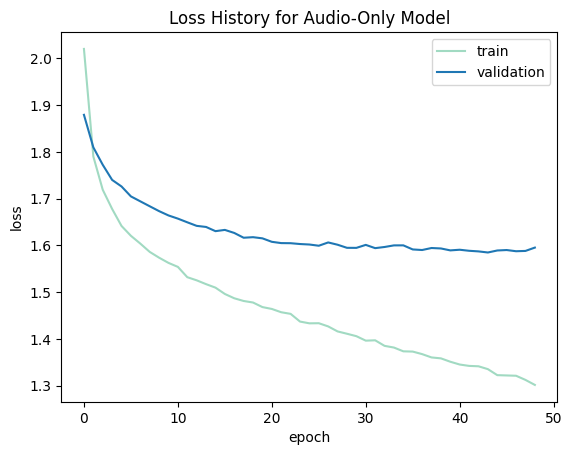

In [63]:
plot_history(audio_history, model='Audio-Only Model', metric='loss', loc='upper right')

In [65]:
audio_model.save(models_path / "audio_model.keras")
audio_logits_model.save(models_path / "audio_logits_model.keras")
# reconstructed_audio_model = keras.models.load_model(models_path / "audio_model.keras")
# reconstructed_audio_logits_model = keras.models.load_model(models_path / "audio_logits_model.keras")

## Make predictions on test set and evaluate

In [49]:
epi, ale, pred = make_disentangled_prediction(audio_logits_model, audio_model, X_test_audio, return_logits=False)
epi_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(epi, axis=1))
ale_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(ale, axis=1))
pred_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(pred, axis=1))
print(f'Predictive accuracy:\t {pred_acc:.4f}\n Aleatoric accuracy:\t {ale_acc:.2f}\n Epistemic accuracy:\t {epi_acc:.2f}')

Predictive accuracy:	 0.4419
 Aleatoric accuracy:	 0.44
 Epistemic accuracy:	 0.44


In [50]:
cce = tf.keras.losses.CategoricalCrossentropy()
print(f'Predictive cce:\t {cce(y_test_onehot, pred):.2f}')

Predictive cce:	 1.53


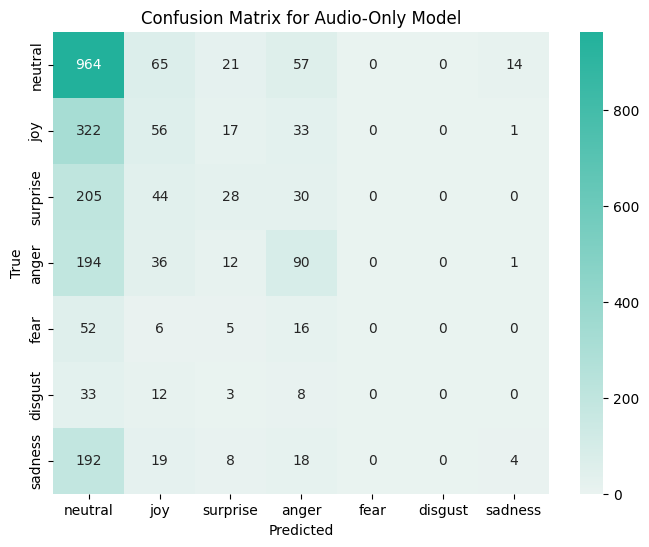

In [118]:
plot_confusion_matrix(np.argmax(y_test_onehot, axis=1), np.argmax(np.array(pred), axis=1), 'Audio-Only')

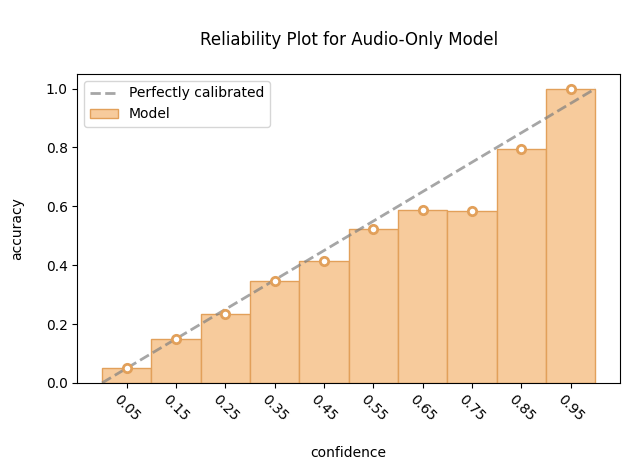

In [119]:
_ = plot_multiclass_calibration_curve(np.array(pred), np.argmax(y_test_onehot, axis=1), bins=10, title='Reliability Plot for Audio-Only Model')

# TEXT-ONLY

## Define model

In [50]:
def build_text_only_model(dense_dims, dropout_rate=0.2, learn_rate=1e-6, num_sfmx=50,
                          num_features=768, num_classes=7, return_logits_model=False):
    input_layer = tf.keras.layers.Input(shape=(num_features,))

    x = tf.keras.layers.Dense(dense_dims[0], activation='relu')(input_layer)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_dims[1], activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_dims[2], activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    logit_mean = Dense(units=num_classes, activation='linear')(x)
    logit_var = Dense(units=num_classes, activation='softplus')(x)

    softmax_output = SamplingSoftmax(num_sfmx)([logit_mean, logit_var])

    pred_model = tf.keras.Model(input_layer, [logit_mean, logit_var])

    model = tf.keras.Model(input_layer, softmax_output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    if return_logits_model:
      return model, pred_model

    return model

def build_t_model(hp, return_logits_model=False):
    unit_dims = [hp.Int("units_0", min_value=128, max_value=512, step=2, sampling='log')]
    unit_dims += [hp.Int("units_1", min_value=64, max_value=256, step=2, sampling='log')]
    unit_dims += [hp.Int("units_2", min_value=32, max_value=128, step=2, sampling='log')]
    unit_dims.sort(reverse=True)

    dropout_rate = hp.Float("dropout rate", min_value=0.1, max_value=0.3, step=0.05)
    learn_rate = hp.Float("learning rate", min_value=1e-6, max_value=1e-3, sampling="log")

    num_samples = hp.Choice("softmax num samples", [50,100,150,200])

    return build_text_only_model(dense_dims=unit_dims,
                                 dropout_rate=dropout_rate,
                                 learn_rate=learn_rate,
                                 num_sfmx=num_samples,
                                 return_logits_model=return_logits_model)

## Hyperparameter search

In [51]:
text_tuner = kt.RandomSearch(build_t_model,
                        objective='val_accuracy',
                        max_trials = 5,
                        seed = SEED,
                        project_name='disentangle_text_tuner',
                        directory='/content/drive/MyDrive/BACHELORS_PROJECT/tuning-history')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Reloading Tuner from /content/drive/MyDrive/BACHELORS_PROJECT/tuning-history/disentangle_text_tuner/tuner0.json


In [52]:
text_tuner.search(X_train_text, y_train_onehot, epochs=300, validation_data=(X_val_text, y_val_onehot), callbacks=[stop_early], batch_size=64)

In [53]:
text_tuner.results_summary(1)

Results summary
Results in /content/drive/MyDrive/BACHELORS_PROJECT/tuning-history/disentangle_text_tuner
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
units_0: 256
units_1: 64
units_2: 128
dropout rate: 0.2
learning rate: 0.000687224844798822
softmax num samples: 150
Score: 0.5611775517463684


## Retrain with best hyperparameters

In [67]:
hyperpars = text_tuner.get_best_hyperparameters()[0]
text_model, text_logits_model = build_t_model(hyperpars, return_logits_model=True)
text_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 dense_30 (Dense)            (None, 256)                  196864    ['input_7[0][0]']             
                                                                                                  
 dropout_18 (Dropout)        (None, 256)                  0         ['dense_30[0][0]']            
                                                                                                  
 dense_31 (Dense)            (None, 128)                  32896     ['dropout_18[0][0]']          
                                                                                           

In [68]:
text_history = text_model.fit(X_train_text, y_train_onehot, epochs=300, validation_data=(X_val_text, y_val_onehot), callbacks=[stop_early], batch_size=64)

Epoch 1/300
156/156 [==============================] - 3s 13ms/step - loss: 1.5967 - accuracy: 0.4375 - val_loss: 1.5541 - val_accuracy: 0.4204
Epoch 2/300
156/156 [==============================] - 2s 14ms/step - loss: 1.4692 - accuracy: 0.4784 - val_loss: 1.4794 - val_accuracy: 0.4784
Epoch 3/300
156/156 [==============================] - 3s 17ms/step - loss: 1.3982 - accuracy: 0.5149 - val_loss: 1.4275 - val_accuracy: 0.4977
Epoch 4/300
156/156 [==============================] - 2s 13ms/step - loss: 1.3616 - accuracy: 0.5243 - val_loss: 1.4192 - val_accuracy: 0.4940
Epoch 5/300
156/156 [==============================] - 2s 11ms/step - loss: 1.3504 - accuracy: 0.5346 - val_loss: 1.3741 - val_accuracy: 0.5152
Epoch 6/300
156/156 [==============================] - 2s 11ms/step - loss: 1.3203 - accuracy: 0.5500 - val_loss: 1.3814 - val_accuracy: 0.5198
Epoch 7/300
156/156 [==============================] - 2s 11ms/step - loss: 1.3104 - accuracy: 0.5470 - val_loss: 1.3903 - val_accuracy:

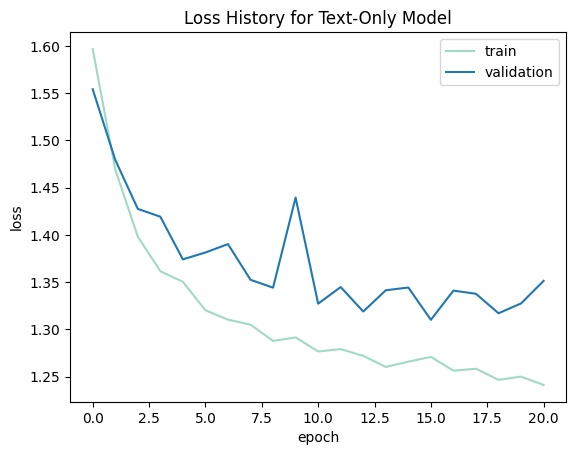

In [69]:
plot_history(text_history, model='Text-Only Model', metric='loss', loc='upper right')

In [70]:
text_model.save(models_path / "text_model.keras")
text_logits_model.save(models_path / "text_logits_model.keras")
# reconstructed_text_model = keras.models.load_model(models_path / "text_model.keras")
# reconstructed_text_logits_model = keras.models.load_model(models_path / "text_logits_model.keras")

## Make predictions on test set and evaluate

In [43]:
epi, ale, pred = make_disentangled_prediction(text_logits_model, text_model, X_test_text, return_logits=False)
epi_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(epi, axis=1))
ale_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(ale, axis=1))
pred_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(pred, axis=1))
print(f'Predictive accuracy:\t {pred_acc:.4f}\n Aleatoric accuracy:\t {ale_acc:.2f}\n Epistemic accuracy:\t {epi_acc:.2f}')

Predictive accuracy:	 0.5772
 Aleatoric accuracy:	 0.57
 Epistemic accuracy:	 0.57


In [38]:
cce = tf.keras.losses.CategoricalCrossentropy()
print(f'Predictive cce:\t {cce(y_test_onehot, pred):.2f}')

Predictive cce:	 1.25


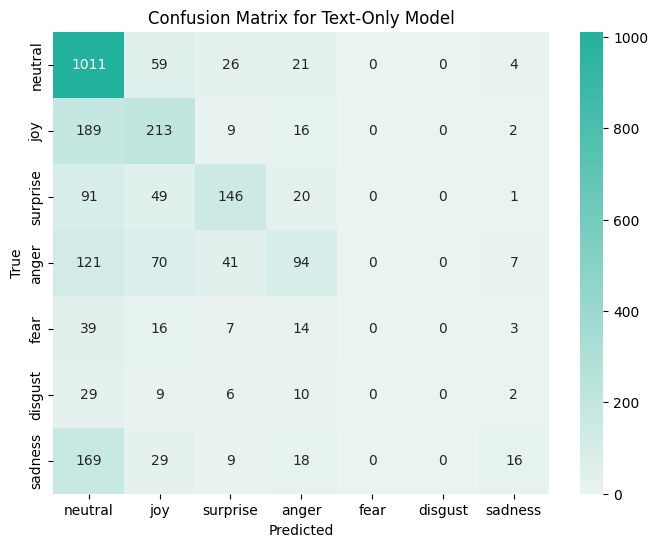

In [104]:
plot_confusion_matrix(np.argmax(y_test_onehot, axis=1), np.argmax(np.array(pred), axis=1), 'Text-Only')

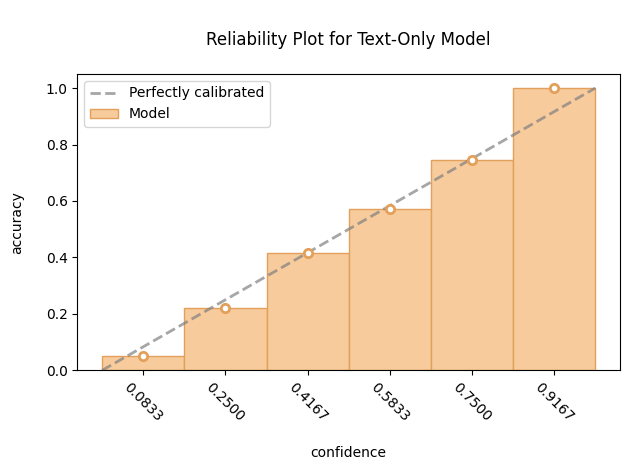

In [111]:
_ = plot_multiclass_calibration_curve(np.array(pred), np.argmax(y_test_onehot, axis=1), bins=6, title='Reliability Plot for Text-Only Model')

# EARLY FUSION

## Define model

In [73]:
def build_early_text_audio_model(dense_dims=[256, 128, 64], dropout_rate=0.1, learn_rate=4.454196493570256e-05, num_text_features=768, num_audio_features=988, num_classes=7, num_samples=50, return_logits_model=False):
    text_input = tf.keras.layers.Input(shape=(num_text_features,))
    audio_input = tf.keras.layers.Input(shape=(num_audio_features,))

    concat_input = keras.layers.Concatenate()([text_input, audio_input])

    x = tf.keras.layers.Dense(dense_dims[0], activation='relu')(concat_input)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_dims[1], activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_dims[2], activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)


    logit_mean = tf.keras.layers.Dense(units=num_classes, activation='linear')(x)
    logit_var = tf.keras.layers.Dense(units=num_classes, activation='softplus')(x)

    softmax_output = SamplingSoftmax(num_samples)([logit_mean, logit_var])

    pred_model = tf.keras.Model([text_input, audio_input], [logit_mean, logit_var])

    model = tf.keras.Model([text_input, audio_input], softmax_output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    if return_logits_model:
      return model, pred_model

    return model

def build_eta_model(hp, return_logits_model=False):
  unit_dims = [hp.Int("units_0", min_value=256, max_value=1024, step=2, sampling='log')]
  unit_dims += [hp.Int("units_1", min_value=128, max_value=512, step=2, sampling='log')]
  unit_dims += [hp.Int("units_2", min_value=32, max_value=256, step=2, sampling='log')]

  unit_dims.sort(reverse=True)

  dropout_rate = hp.Float("dropout rate", min_value=0, max_value=0.3, step=0.05)
  learn_rate = hp.Float("learning rate", min_value=1e-7, max_value=1e-3, sampling="log")

  num_samples = hp.Choice("softmax num samples", [50,100,150,200])

  return build_early_text_audio_model(dense_dims=unit_dims,
                                 dropout_rate=dropout_rate,
                                 learn_rate=learn_rate,
                                 num_samples=num_samples,
                                 return_logits_model=return_logits_model)

## Hyperparameter search

In [74]:
eta_tuner = kt.RandomSearch(build_eta_model,
                     objective='val_accuracy',
                     max_trials = 10,
                     seed = SEED,
                     project_name='disentangle_eta_tuner', directory='/content/drive/MyDrive/BACHELORS_PROJECT/tuning-history')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Reloading Tuner from /content/drive/MyDrive/BACHELORS_PROJECT/tuning-history/disentangle_eta_tuner/tuner0.json


In [75]:
eta_tuner.search(X_train_both, y_train_onehot, epochs=300, validation_data=(X_val_both, y_val_onehot), callbacks=[stop_early], batch_size=64)

In [76]:
eta_tuner.results_summary(1)

Results summary
Results in /content/drive/MyDrive/BACHELORS_PROJECT/tuning-history/disentangle_eta_tuner
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
units_0: 512
units_1: 128
units_2: 256
dropout rate: 0.1
learning rate: 4.454196493570256e-05
softmax num samples: 50
Score: 0.5234590768814087


## Retrain with best hyperparameters

In [77]:
hyperpars = eta_tuner.get_best_hyperparameters()[0]
eta_model, eta_logits_model = build_eta_model(hyperpars, return_logits_model=True)
eta_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 988)]                0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 1756)                 0         ['input_8[0][0]',             
                                                                     'input_9[0][0]']             
                                                                                                  
 dense_35 (Dense)            (None, 512)                  899584    ['concatenate[0][0]']  

In [79]:
eta_history = eta_model.fit(X_train_both, y_train_onehot, epochs=300, validation_data=(X_val_both, y_val_onehot), callbacks=[stop_early], batch_size=64)

Epoch 1/300
156/156 [==============================] - 12s 44ms/step - loss: 1.6345 - accuracy: 0.4197 - val_loss: 1.5984 - val_accuracy: 0.4278
Epoch 2/300
156/156 [==============================] - 5s 29ms/step - loss: 1.5009 - accuracy: 0.4587 - val_loss: 1.5510 - val_accuracy: 0.4379
Epoch 3/300
156/156 [==============================] - 3s 19ms/step - loss: 1.4370 - accuracy: 0.4878 - val_loss: 1.5285 - val_accuracy: 0.4434
Epoch 4/300
156/156 [==============================] - 3s 19ms/step - loss: 1.3932 - accuracy: 0.5006 - val_loss: 1.5072 - val_accuracy: 0.4462
Epoch 5/300
156/156 [==============================] - 3s 19ms/step - loss: 1.3506 - accuracy: 0.5149 - val_loss: 1.4835 - val_accuracy: 0.4609
Epoch 6/300
156/156 [==============================] - 5s 29ms/step - loss: 1.3095 - accuracy: 0.5266 - val_loss: 1.4700 - val_accuracy: 0.4673
Epoch 7/300
156/156 [==============================] - 3s 20ms/step - loss: 1.2675 - accuracy: 0.5430 - val_loss: 1.4503 - val_accuracy

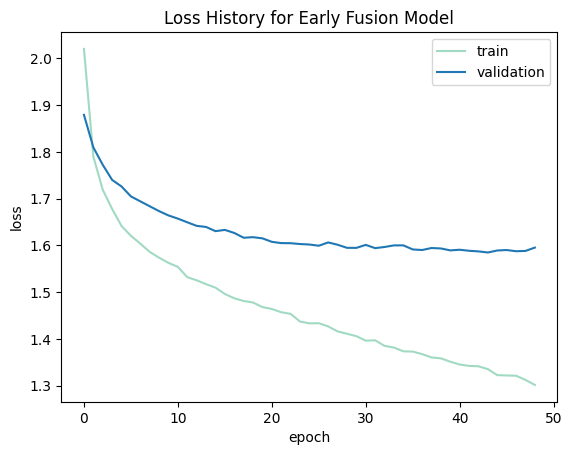

In [80]:
plot_history(audio_history, model='Early Fusion Model', metric='loss', loc='upper right')

In [81]:
eta_model.save(models_path / "eta_model.keras")
eta_logits_model.save(models_path / "eta_logits_model.keras")
# eta_model = keras.models.load_model(models_path / "eta_model.keras")
# eta_logits_model = keras.models.load_model(models_path / "eta_logits_model.keras")

## Make predictions on test set and evaluate

In [44]:
epi, ale, pred = make_disentangled_prediction(eta_logits_model, eta_model, X_test_both, return_logits=False)
epi_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(epi, axis=1))
ale_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(ale, axis=1))
pred_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(pred, axis=1))
print(f'Predictive accuracy:\t {pred_acc:.4f}\n Aleatoric accuracy:\t {ale_acc:.2f}\n Epistemic accuracy:\t {epi_acc:.2f}')

Predictive accuracy:	 0.5273
 Aleatoric accuracy:	 0.53
 Epistemic accuracy:	 0.53


In [35]:
cce = tf.keras.losses.CategoricalCrossentropy()
print(f'Predictive cce:\t {cce(y_test_onehot, pred):.2f}')

Predictive cce:	 1.34


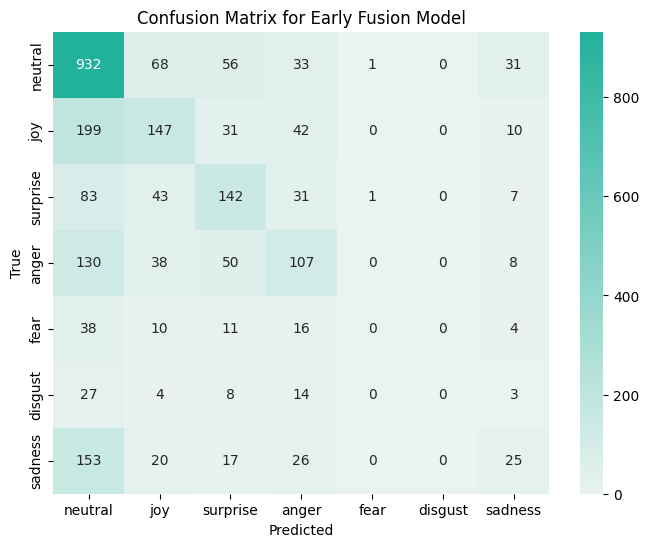

In [89]:
plot_confusion_matrix(np.argmax(y_test_onehot, axis=1), np.argmax(np.array(pred), axis=1), 'Early Fusion')

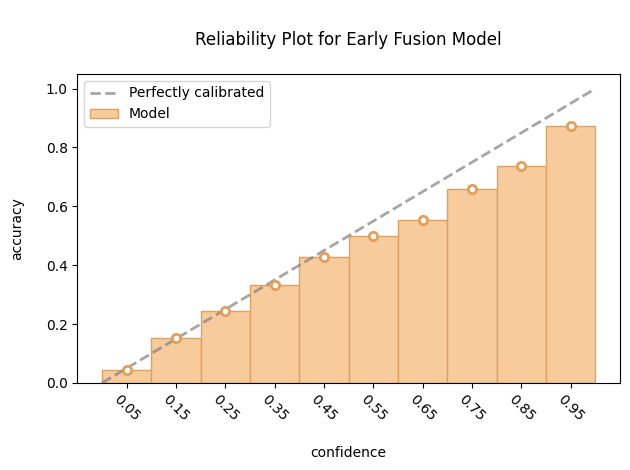

In [90]:
_ = plot_multiclass_calibration_curve(np.array(pred), np.argmax(y_test_onehot, axis=1), bins=10, title='Reliability Plot for Early Fusion Model')

# INTERMEDIATE FUSION

## Define model

In [14]:
def build_interm_text_audio_model(dense_dims, embedding_dim, fusion_type='concat', dropout_rate=0.2, learn_rate=1e-6, num_text_features=768, num_audio_features=988, num_classes=7, num_samples=50, return_logits_model=False):
    text_input = tf.keras.layers.Input(shape=(num_text_features,))
    audio_input = tf.keras.layers.Input(shape=(num_audio_features,))

    text_embedding = tf.keras.layers.Dense(embedding_dim, activation='relu')(text_input)
    audio_embedding = tf.keras.layers.Dense(embedding_dim, activation='relu')(audio_input)

    if fusion_type == 'concat':
      fused = keras.layers.Concatenate()([text_embedding, audio_embedding])
    elif fusion_type == 'add':
      fused = keras.layers.Add()([text_embedding, audio_embedding])
    elif fusion_type == 'multiply':
      fused =fused = keras.layers.Multiply()([text_embedding, audio_embedding])

    x = tf.keras.layers.Dense(dense_dims[0], activation='relu')(fused)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_dims[1], activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(dense_dims[2], activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    logit_mean = tf.keras.layers.Dense(units=num_classes, activation='linear')(x)
    logit_var = tf.keras.layers.Dense(units=num_classes, activation='softplus')(x)

    softmax_output = SamplingSoftmax(num_samples)([logit_mean, logit_var])

    pred_model = tf.keras.Model([text_input, audio_input], [logit_mean, logit_var])

    model = tf.keras.Model([text_input, audio_input], softmax_output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    if return_logits_model:
      return model, pred_model

    return model

def build_ita_model(hp, return_logits_model=False):
  unit_dims = [hp.Int("units_0", min_value=128, max_value=512, step=2, sampling='log')]
  unit_dims += [hp.Int("units_1", min_value=64, max_value=256, step=2, sampling='log')]
  unit_dims += [hp.Int("units_2", min_value=32, max_value=128, step=2, sampling='log')]
  unit_dims.sort(reverse=True)

  fusion_type = hp.Choice("fusion", ['concat', 'add', 'multiply'])
  embedding_dim = hp.Choice("embedding dim", [200, 300, 400, 500])

  dropout_rate = hp.Float("dropout rate", min_value=0.1, max_value=0.3, step=0.05)
  learn_rate = hp.Float("learning rate", min_value=1e-7, max_value=1e-3, sampling="log")

  num_samples = hp.Choice("softmax num samples", [50,100,150,200])

  return build_interm_text_audio_model(dense_dims=unit_dims,
                                        embedding_dim=embedding_dim,
                                        fusion_type=fusion_type,
                                        dropout_rate=dropout_rate,
                                        learn_rate=learn_rate,
                                        num_samples=num_samples,
                                        return_logits_model=return_logits_model)

## Hyperparameter search

In [15]:
ita_tuner = kt.RandomSearch(build_ita_model,
                     objective='val_accuracy',
                     max_trials = 10,
                     seed = SEED,
                     project_name='disentangle_ita_tuner', directory='/content/drive/MyDrive/BACHELORS_PROJECT/tuning-history')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Reloading Tuner from /content/drive/MyDrive/BACHELORS_PROJECT/tuning-history/disentangle_ita_tuner/tuner0.json


In [16]:
ita_tuner.search(X_train_both, y_train_onehot, epochs=300, validation_data=(X_val_both, y_val_onehot), callbacks=[stop_early], batch_size=64)

In [17]:
ita_tuner.results_summary(1)

Results summary
Results in /content/drive/MyDrive/BACHELORS_PROJECT/tuning-history/disentangle_ita_tuner
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 08 summary
Hyperparameters:
units_0: 512
units_1: 128
units_2: 128
fusion: concat
embedding dim: 400
dropout rate: 0.2
learning rate: 4.664276805358194e-06
softmax num samples: 50
Score: 0.5243790149688721


## Retrain with best hyperparameters

In [18]:
hyperpars = ita_tuner.get_best_hyperparameters()[0]
ita_model, ita_logits_model = build_ita_model(hyperpars, return_logits_model=True)
ita_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 988)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 400)                  307600    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 400)                  395600    ['input_2[0][0]']             
                                                                                            

In [19]:
ita_history = ita_model.fit(X_train_both, y_train_onehot, epochs=300, validation_data=(X_val_both, y_val_onehot), callbacks=[stop_early], batch_size=64)

Epoch 1/300
156/156 [==============================] - 6s 29ms/step - loss: 1.9305 - accuracy: 0.2080 - val_loss: 1.7603 - val_accuracy: 0.3818
Epoch 2/300
156/156 [==============================] - 4s 28ms/step - loss: 1.7516 - accuracy: 0.3768 - val_loss: 1.6882 - val_accuracy: 0.3836
Epoch 3/300
156/156 [==============================] - 7s 46ms/step - loss: 1.6807 - accuracy: 0.4145 - val_loss: 1.6614 - val_accuracy: 0.3873
Epoch 4/300
156/156 [==============================] - 7s 46ms/step - loss: 1.6511 - accuracy: 0.4239 - val_loss: 1.6464 - val_accuracy: 0.3891
Epoch 5/300
156/156 [==============================] - 8s 49ms/step - loss: 1.6336 - accuracy: 0.4291 - val_loss: 1.6290 - val_accuracy: 0.3864
Epoch 6/300
156/156 [==============================] - 5s 33ms/step - loss: 1.6168 - accuracy: 0.4322 - val_loss: 1.6227 - val_accuracy: 0.3882
Epoch 7/300
156/156 [==============================] - 7s 45ms/step - loss: 1.5958 - accuracy: 0.4367 - val_loss: 1.6110 - val_accuracy:

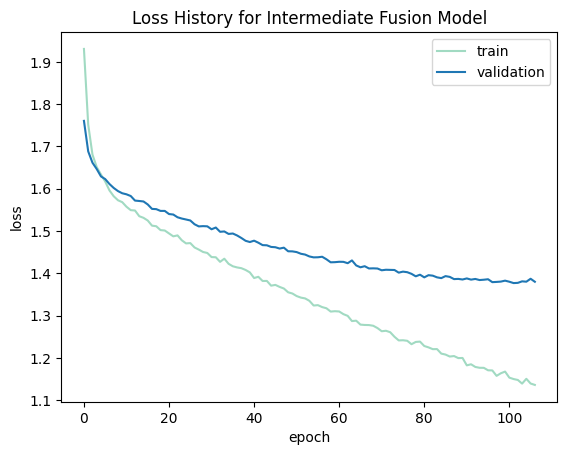

In [20]:
plot_history(ita_history, model='Intermediate Fusion Model', metric='loss', loc='upper right')

In [21]:
ita_model.save(models_path / "ita_model.keras")
ita_logits_model.save(models_path / "ita_logits_model.keras")
# reconstructed_ita_model = keras.models.load_model(models_path / "ita_model.keras")
# reconstructed_ita_logits_model = keras.models.load_model(models_path / "ita_logits_model.keras")

## Make predictions on test set and evaluate

In [48]:
epi, ale, pred = make_disentangled_prediction(ita_logits_model, ita_model, X_test_both, return_logits=False)
epi_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(epi, axis=1))
ale_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(ale, axis=1))
pred_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(pred, axis=1))
print(f'Predictive accuracy:\t {pred_acc:.4f}\n Aleatoric accuracy:\t {ale_acc:.2f}\n Epistemic accuracy:\t {epi_acc:.2f}')
cce = tf.keras.losses.CategoricalCrossentropy()
print(f'Predictive cce:\t {cce(y_test_onehot, pred):.2f}')

Predictive accuracy:	 0.5351
 Aleatoric accuracy:	 0.54
 Epistemic accuracy:	 0.53
Predictive cce:	 1.30


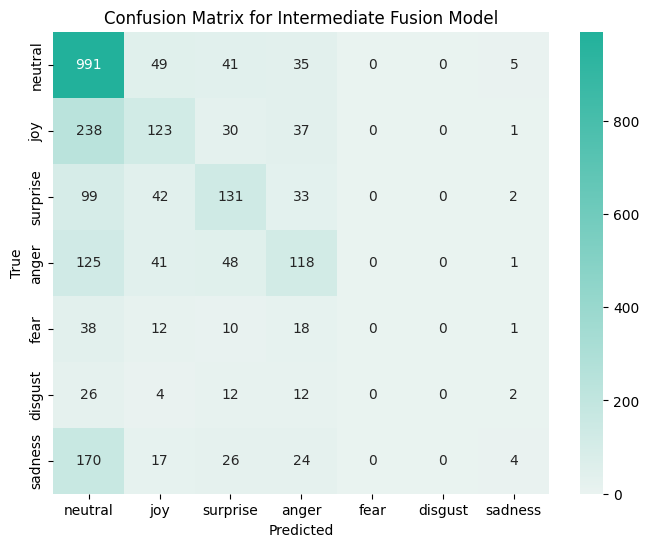

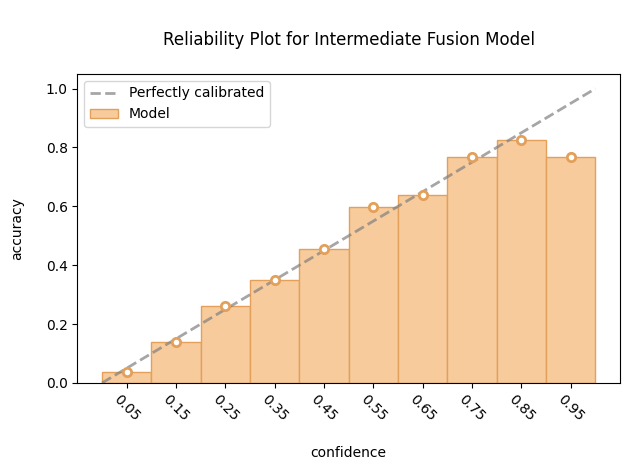

In [23]:
plot_confusion_matrix(np.argmax(y_test_onehot, axis=1), np.argmax(np.array(pred), axis=1), 'Intermediate Fusion')
_ = plot_multiclass_calibration_curve(np.array(pred), np.argmax(y_test_onehot, axis=1), bins=10, title='Reliability Plot for Intermediate Fusion Model')

# LATE FUSION

## Define model

In [24]:
def build_late_text_audio_model(dense_dims_text, dense_dims_audio, dense_dim_fus, fusion_type='concat', dropout_rate=0.2, learn_rate=1e-6, num_text_features=768, num_audio_features=988, num_classes=7, num_samples=50, return_logits_model=False):
    text_input = tf.keras.layers.Input(shape=(num_text_features,))
    audio_input = tf.keras.layers.Input(shape=(num_audio_features,))

    hidden_text = tf.keras.layers.Dense(dense_dims_text[0], activation='relu')(text_input)
    hidden_text = tf.keras.layers.Dropout(dropout_rate)(hidden_text)
    hidden_text = tf.keras.layers.Dense(dense_dims_text[1], activation='relu')(hidden_text)
    hidden_text = tf.keras.layers.Dropout(dropout_rate)(hidden_text)
    hidden_text = tf.keras.layers.Dense(dense_dims_text[2], activation='relu')(hidden_text)

    hidden_audio = tf.keras.layers.Dense(dense_dims_text[0], activation='relu')(audio_input)
    hidden_audio = tf.keras.layers.Dropout(dropout_rate)(hidden_audio)
    hidden_audio = tf.keras.layers.Dense(dense_dims_text[1], activation='relu')(hidden_audio)
    hidden_audio = tf.keras.layers.Dropout(dropout_rate)(hidden_audio)
    hidden_audio = tf.keras.layers.Dense(dense_dims_text[2], activation='relu')(hidden_audio)

    if fusion_type == 'concat':
        fused = tf.keras.layers.Concatenate()([hidden_text, hidden_audio])
    elif fusion_type == 'add':
        fused = tf.keras.layers.Add()([hidden_text, hidden_audio])
    elif fusion_type == 'multiply':
        fused = tf.keras.layers.Multiply()([hidden_text, hidden_audio])

    if dense_dim_fus == 0:
        hidden = fused
    else:
        hidden = tf.keras.layers.Dense(dense_dim_fus, activation='relu')(fused)

    hidden = tf.keras.layers.Dropout(dropout_rate)(hidden)

    logit_mean = tf.keras.layers.Dense(units=num_classes, activation='linear')(hidden)
    logit_var = tf.keras.layers.Dense(units=num_classes, activation='softplus')(hidden)

    softmax_output = SamplingSoftmax(num_samples)([logit_mean, logit_var])

    pred_model = tf.keras.Model([text_input, audio_input], [logit_mean, logit_var])

    model = tf.keras.Model([text_input, audio_input], softmax_output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    if return_logits_model:
        return model, pred_model

    return model

def build_lta_model(hp, return_logits_model=False):
    unit_dims_text = [hp.Int("tunits_0", min_value=128, max_value=512, step=2, sampling='log')]
    unit_dims_text += [hp.Int("tunits_1", min_value=64, max_value=256, step=2, sampling='log')]
    unit_dims_text += [hp.Int("tunits_2", min_value=32, max_value=128, step=2, sampling='log')]
    unit_dims_text.sort(reverse=True)

    unit_dims_audio = [hp.Int("aunits_0", min_value=128, max_value=512, step=2, sampling='log')]
    unit_dims_audio += [hp.Int("aunits_1", min_value=64, max_value=256, step=2, sampling='log')]
    unit_dims_audio += [hp.Int("aunits_2", min_value=32, max_value=128, step=2, sampling='log')]
    unit_dims_audio.sort(reverse=True)

    unit_dim_fus = hp.Int("fus units", min_value=0, max_value=128, step=16)

    fusion_type = hp.Choice("fusion", ['concat', 'add', 'multiply'])

    dropout_rate = hp.Float("dropout rate", min_value=0.1, max_value=0.3, step=0.05)
    learn_rate = hp.Float("learning rate", min_value=1e-7, max_value=1e-3, sampling="log")

    num_samples = hp.Choice("softmax num samples", [50,100,150,200])

    return build_late_text_audio_model(dense_dims_text=unit_dims_text,
                                      dense_dims_audio=unit_dims_audio,
                                      dense_dim_fus=unit_dim_fus,
                                      fusion_type=fusion_type,
                                      dropout_rate=dropout_rate,
                                      learn_rate=learn_rate,
                                      num_samples=num_samples,
                                      return_logits_model=return_logits_model)

## Hyperparameter search

In [25]:
lta_tuner = kt.RandomSearch(build_lta_model,
                     objective='val_accuracy',
                     max_trials = 10,
                     seed = SEED,
                     project_name='disentangle_lta_tuner', directory='/content/drive/MyDrive/BACHELORS_PROJECT/tuning-history')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Reloading Tuner from /content/drive/MyDrive/BACHELORS_PROJECT/tuning-history/disentangle_lta_tuner/tuner0.json


In [26]:
lta_tuner.search(X_train_both, y_train_onehot, epochs=300, validation_data=(X_val_both, y_val_onehot), callbacks=[stop_early], batch_size=64)

In [27]:
lta_tuner.results_summary(1)

Results summary
Results in /content/drive/MyDrive/BACHELORS_PROJECT/tuning-history/disentangle_lta_tuner
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
tunits_0: 256
tunits_1: 128
tunits_2: 128
aunits_0: 256
aunits_1: 128
aunits_2: 32
fus units: 32
fusion: multiply
dropout rate: 0.2
learning rate: 1.8549641064416335e-05
softmax num samples: 100
Score: 0.5620974898338318


## Retrain with best hyperparameters

In [28]:
hyperpars = lta_tuner.get_best_hyperparameters()[0]
lta_model, lta_logits_model = build_lta_model(hyperpars, return_logits_model=True)
lta_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 988)]                0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 256)                  196864    ['input_3[0][0]']             
                                                                                                  
 dense_10 (Dense)            (None, 256)                  253184    ['input_4[0][0]']             
                                                                                            

In [29]:
lta_history = lta_model.fit(X_train_both, y_train_onehot, epochs=300, validation_data=(X_val_both, y_val_onehot), callbacks=[stop_early], batch_size=64)

Epoch 1/300
156/156 [==============================] - 11s 25ms/step - loss: 1.8079 - accuracy: 0.3233 - val_loss: 1.7307 - val_accuracy: 0.3864
Epoch 2/300
156/156 [==============================] - 3s 20ms/step - loss: 1.6692 - accuracy: 0.4152 - val_loss: 1.6662 - val_accuracy: 0.3873
Epoch 3/300
156/156 [==============================] - 5s 29ms/step - loss: 1.6328 - accuracy: 0.4241 - val_loss: 1.6393 - val_accuracy: 0.3974
Epoch 4/300
156/156 [==============================] - 4s 27ms/step - loss: 1.6039 - accuracy: 0.4331 - val_loss: 1.6254 - val_accuracy: 0.3983
Epoch 5/300
156/156 [==============================] - 4s 27ms/step - loss: 1.5903 - accuracy: 0.4396 - val_loss: 1.6137 - val_accuracy: 0.4085
Epoch 6/300
156/156 [==============================] - 4s 27ms/step - loss: 1.5706 - accuracy: 0.4433 - val_loss: 1.5981 - val_accuracy: 0.4213
Epoch 7/300
156/156 [==============================] - 4s 27ms/step - loss: 1.5567 - accuracy: 0.4441 - val_loss: 1.5849 - val_accuracy

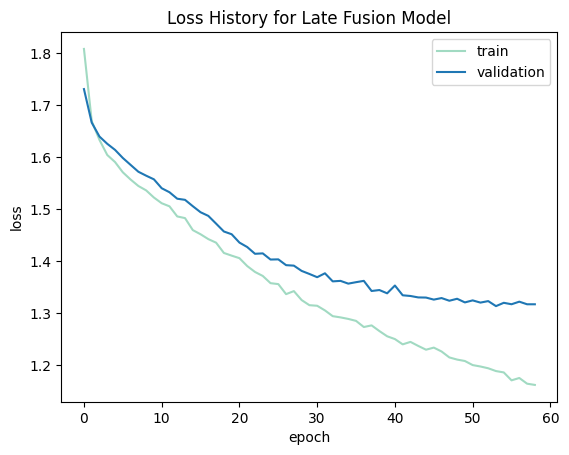

In [30]:
plot_history(lta_history, model='Late Fusion Model', metric='loss', loc='upper right')

In [31]:
lta_model.save(models_path / "lta_model.keras")
lta_logits_model.save(models_path / "lta_logits_model.keras")
# reconstructed_lta_model = keras.models.load_model(models_path / "lta_model.keras")
# reconstructed_lta_logits_model = keras.models.load_model(models_path / "lta_logits_model.keras")

## Make predictions on test set and evaluate

In [46]:
epi, ale, pred = make_disentangled_prediction(lta_logits_model, lta_model, X_test_both, return_logits=False)
epi_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(epi, axis=1))
ale_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(ale, axis=1))
pred_acc = accuracy_score(np.argmax(y_test_onehot, axis=1), np.argmax(pred, axis=1))
print(f'Predictive accuracy:\t {pred_acc:.4f}\n Aleatoric accuracy:\t {ale_acc:.2f}\n Epistemic accuracy:\t {epi_acc:.2f}')
cce = tf.keras.losses.CategoricalCrossentropy()
print(f'Predictive cce:\t {cce(y_test_onehot, pred):.2f}')

Predictive accuracy:	 0.5698
 Aleatoric accuracy:	 0.57
 Epistemic accuracy:	 0.57
Predictive cce:	 1.25


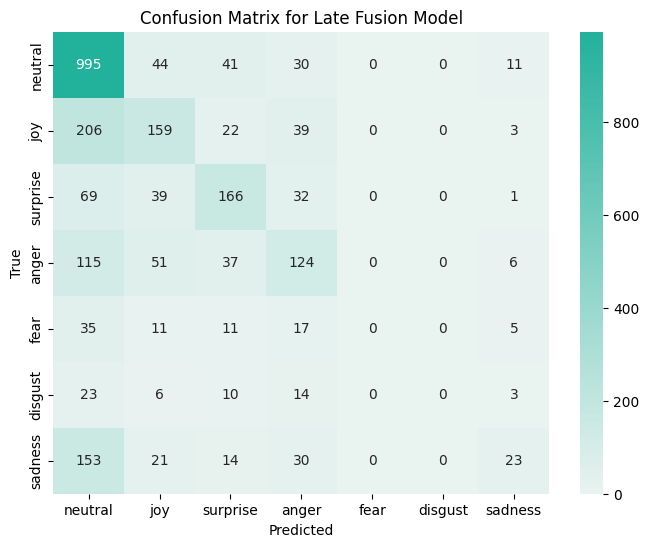

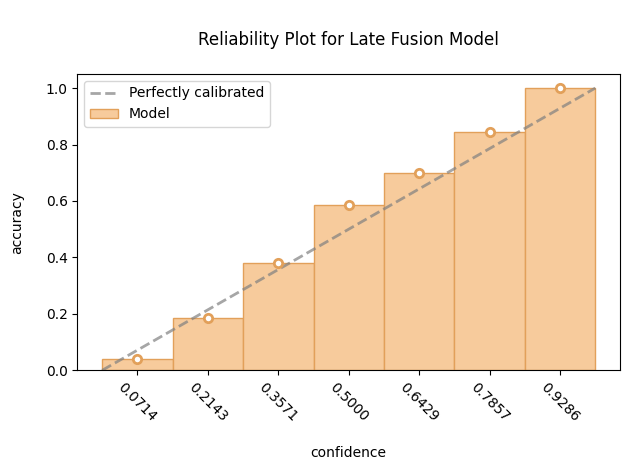

In [39]:
plot_confusion_matrix(np.argmax(y_test_onehot, axis=1), np.argmax(np.array(pred), axis=1), 'Late Fusion')
_ = plot_multiclass_calibration_curve(np.array(pred), np.argmax(y_test_onehot, axis=1), bins=7, title='Reliability Plot for Late Fusion Model')

# Uncertainty disentanglement plot

In [1]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/BACHELORS_PROJECT/data/processed/processed_func_data.csv', dtype={'id':str})
df.tail(5)

,filename,id,conversation_line,emotion,speaker,pcm_intensity_sma_max,pcm_intensity_sma_min,pcm_intensity_sma_range,pcm_intensity_sma_maxPos,pcm_intensity_sma_minPos,...,F0env_sma_de_stddev,F0env_sma_de_skewness,F0env_sma_de_kurtosis,F0env_sma_de_quartile1,F0env_sma_de_quartile2,F0env_sma_de_quartile3,F0env_sma_de_iqr1-2,F0env_sma_de_iqr2-3,F0env_sma_de_iqr1-3,split
13614,dia1374utt1,13730,"I never sucked , I actually did not want you t...",neutral,Chandler,7.058507e-07,1.210246e-12,7.058495e-07,359.0,439.0,...,8.068659,3.608357,26.848444,-0.808801,0.000000,0.575753,0.808801,0.575753,1.384554,test
13615,dia1374utt2,13731,Why ?,surprise,Monica,3.722622e-07,1.460661e-12,3.722608e-07,6.0,128.0,...,8.287781,2.082116,7.733343,0.000000,0.000000,1.673672,0.000000,1.673672,1.673672,test
13616,dia1374utt3,13732,I do not know .,neutral,Chandler,3.563152e-07,1.564599e-08,3.406692e-07,21.0,12.0,...,6.646890,1.203715,3.324758,2.844861,4.440066,9.270791,1.595205,4.830725,6.425930,test
13617,dia1374utt4,13733,This is so great ! Now we can enter into doubl...,joy,Monica,1.347629e-06,4.590557e-13,1.347629e-06,483.0,74.0,...,6.469358,3.582012,33.893820,-0.999576,0.000000,1.920473,0.999576,1.920473,2.920049,test
13618,dia1374utt5,13734,That is why !,neutral,Chandler,8.009187e-07,6.547851e-11,8.008532e-07,275.0,225.0,...,8.450015,5.388104,39.999100,-1.469423,0.000000,0.404643,1.469423,0.404643,1.874066,test


In [2]:
lines5 = df.tail(5)['conversation_line'].reset_index().drop(columns=['index'])
lines5

,conversation_line
0,"I never sucked , I actually did not want you t..."
1,Why ?
2,I do not know .
3,This is so great ! Now we can enter into doubl...
4,That is why !


In [9]:
num_sfmx = [100, 150, 50, 50, 100]

audio_model = keras.models.load_model(models_path / "audio_model.keras")
audio_logits_model = keras.models.load_model(models_path / "audio_logits_model.keras")

text_model = keras.models.load_model(models_path / "text_model.keras")
text_logits_model = keras.models.load_model(models_path / "text_logits_model.keras")

eta_model = keras.models.load_model(models_path / "eta_model.keras")
eta_logits_model = keras.models.load_model(models_path / "eta_logits_model.keras")

ita_model = keras.models.load_model(models_path / "ita_model.keras")
ita_logits_model = keras.models.load_model(models_path / "ita_logits_model.keras")

lta_model = keras.models.load_model(models_path / "lta_model.keras")
lta_logits_model = keras.models.load_model(models_path / "lta_logits_model.keras")

models = [(audio_model, audio_logits_model),
          (text_model, text_logits_model),
          (eta_model, eta_logits_model),
          (ita_model, ita_logits_model),
          (lta_model, lta_logits_model)]

model_names = ['Audio-Only', 'Text-Only', 'Early Fusion', 'Intermediate Fusion', 'Late Fusion']

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
def plot_subplot_with_uncertainty(probs, entropy, ax, palette, title=None):
    labels = ['neutral', 'joy', 'surprise', 'anger', 'disgust', 'fear', 'sadness']
    sns.barplot(x=labels, y=probs, palette=palette, hue=labels, legend=False, ax=ax)

    if title is not None:
        ax.set_title(title, fontsize=16)

    ax.set_ylim(0, 1)
    for i, prob in enumerate(probs):
        ax.text(i, prob + 0.02, f'{prob:.2f}', ha='center', va='bottom')

    ax.text(4.2, 0.9, f'Entropy: {entropy:.2f}')

def plot_probs_with_uncertainty(models, y_true, inp_audio, inp_text, inp_both, line):
    fig, axes = plt.subplots(3, 6, figsize=(24, 12))
    #fig.tight_layout(pad=4.0)

    labels = ['neutral', 'joy', 'surprise', 'anger', 'disgust', 'fear', 'sadness']
    num_classes = len(labels)
    palette = sns.color_palette("Set2", num_classes)

    true_barplot = sns.barplot(x=labels, y=np.array(y_true[0]), palette=palette, hue=labels, dodge=False, ax=axes[0, 0], legend=True)
    axes[0, 0].set_title('Ground Truth')
    axes[0, 0].set_ylim(0, 1)

    for col in range(1, len(models) + 1):
        if col-1 == 0:
            inp = inp_audio
        elif col-1 == 1:
            inp = inp_text
        else:
            inp = inp_both

        epi, ale, pred = make_disentangled_prediction(models[col-1][1], models[col-1][0], inp, num_sfmx=100, return_logits=False)

        epi_entropy = entropy(y_true, epi)
        ale_entropy = entropy(y_true, ale)
        pred_entropy = entropy(y_true, pred)

        epi_probabilities = np.array(epi).flatten()
        ale_probabilities = np.array(ale).flatten()
        pred_probabilities = np.array(pred).flatten()

        plot_subplot_with_uncertainty(pred_probabilities, pred_entropy, axes[0, col], palette, title=model_names[col-1])
        plot_subplot_with_uncertainty(ale_probabilities, ale_entropy, axes[1, col], palette)
        plot_subplot_with_uncertainty(epi_probabilities, epi_entropy, axes[2, col], palette)

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])

    axes[1, 0].set_visible(False)
    axes[2, 0].set_visible(False)

    handles, labels = true_barplot.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncols=7, fontsize=16)

    fig.text(0.04, 0.76, 'Predicted Probability', va='center', ha='center', rotation='vertical', fontsize=16)
    fig.text(0.04, 0.48, 'Aleatoric Probability', va='center', ha='center', rotation='vertical', fontsize=16)
    fig.text(0.04, 0.20, 'Epistemic Probability', va='center', ha='center', rotation='vertical', fontsize=16)

    #fig.suptitle('Different Model Predictions with Disentangled Uncertainties\n "\textit{' + line + '}"', fontsize=28)

    fig.suptitle('')
    fig.text(0.5, 1.02, 'Model Predictions with Disentangled Uncertainties for', ha='center', fontsize=26)
    fig.text(0.5, 0.96, '"' + line + '"', ha='center', fontsize=26, fontstyle='italic')


    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    fig.subplots_adjust(top=0.88)


    axes[0, 0].legend_.remove()



Text:	 ['I never sucked , I actually did not want you to know how good I was !']

Text:	 ['Why ?']

Text:	 ['I do not know .']

Text:	 ['This is so great ! Now we can enter into doubles tournaments !']

Text:	 ['That is why !']



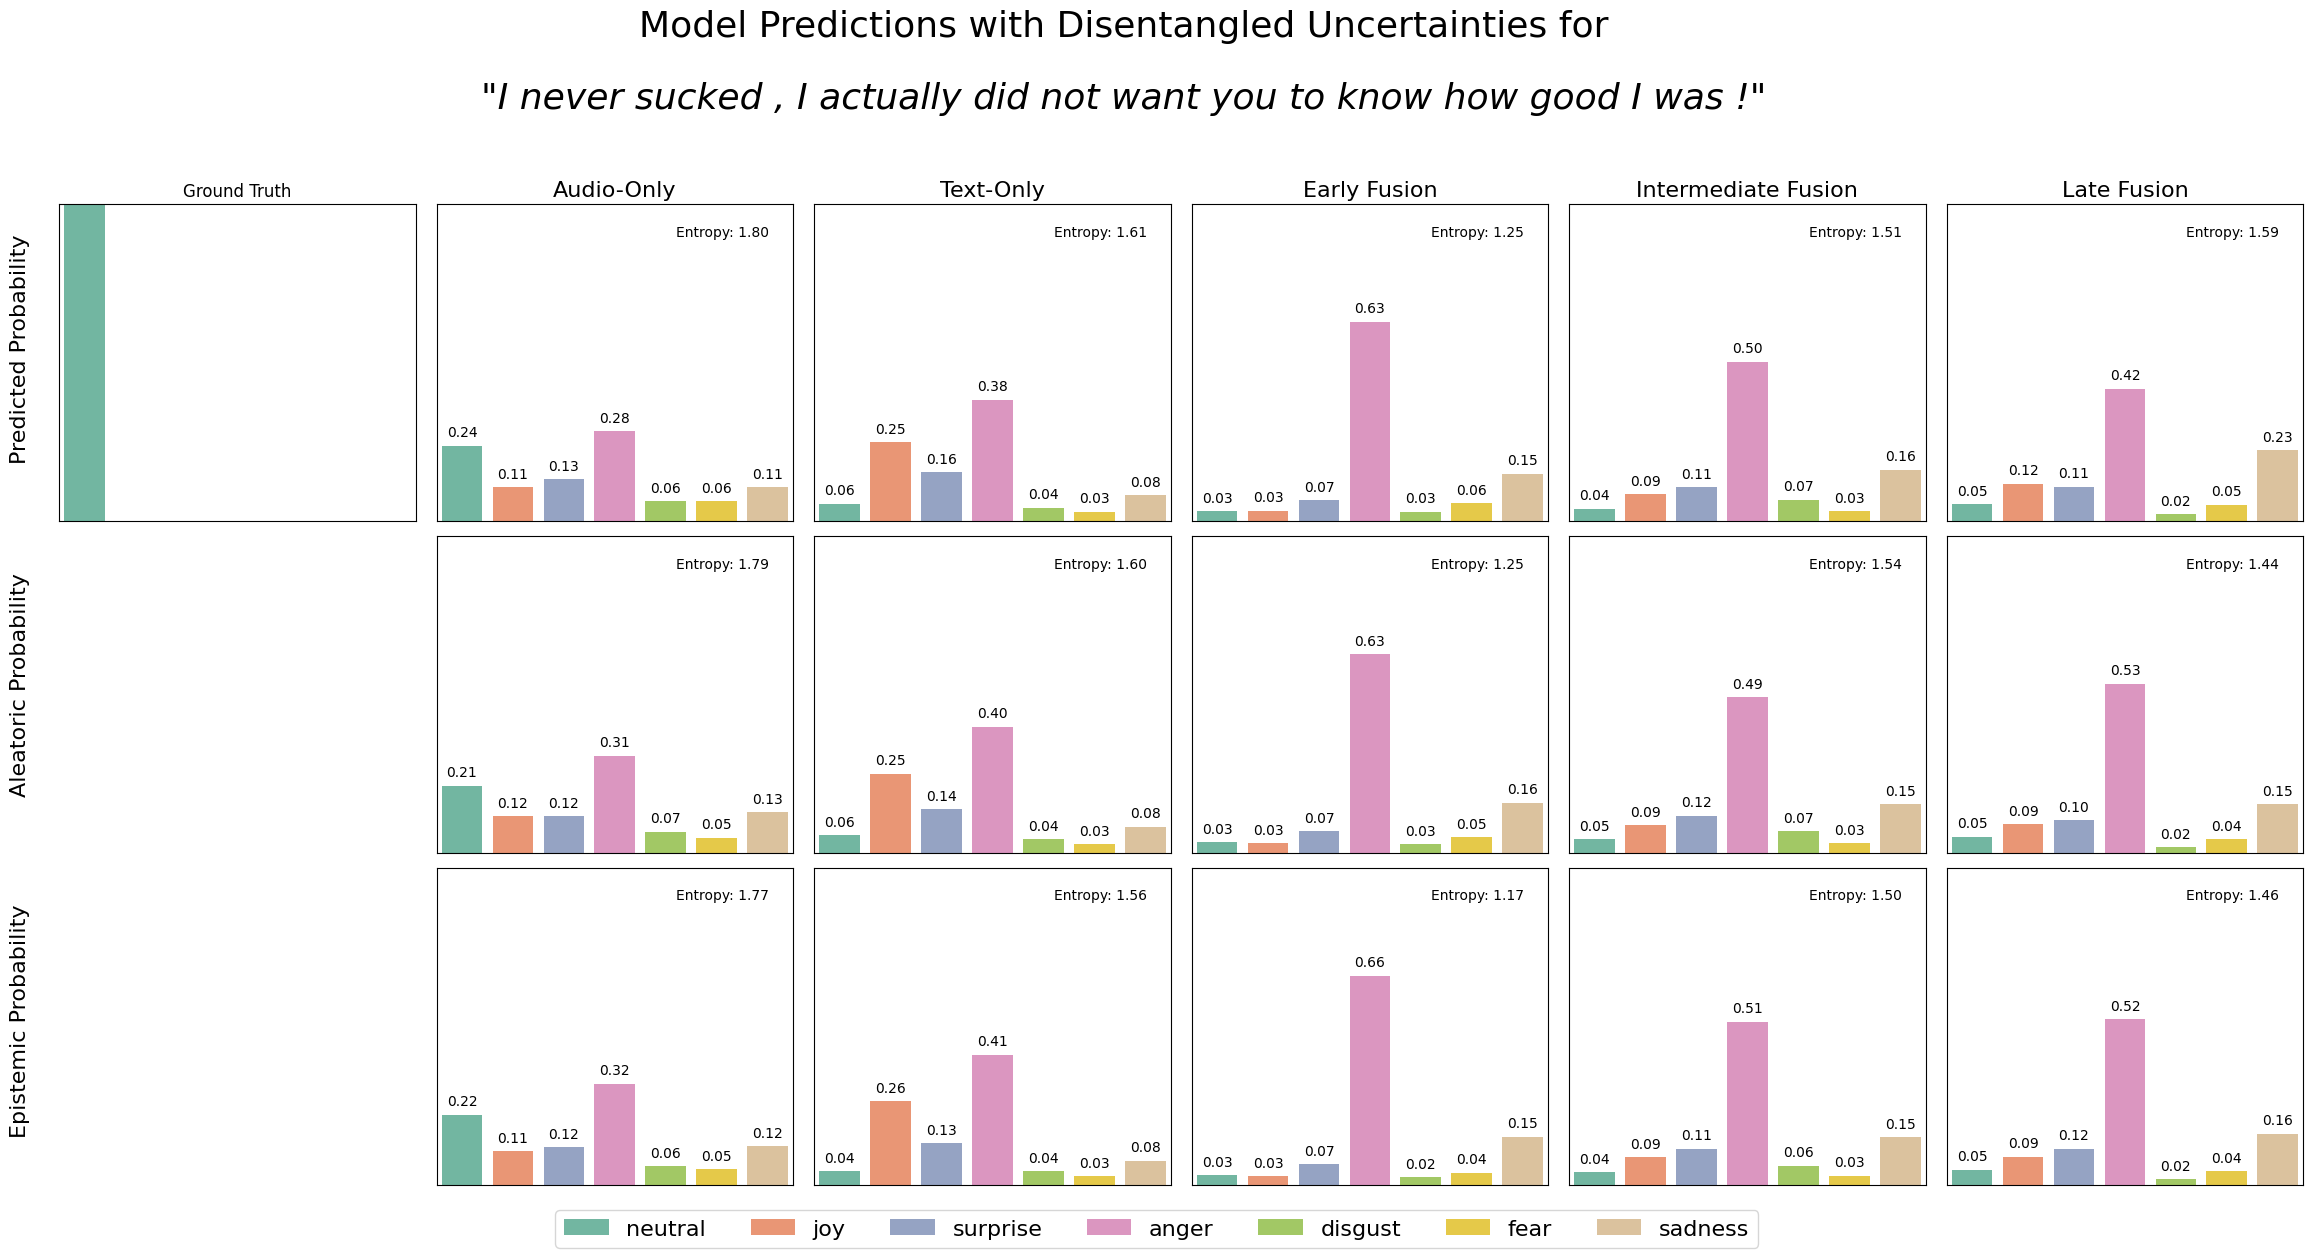

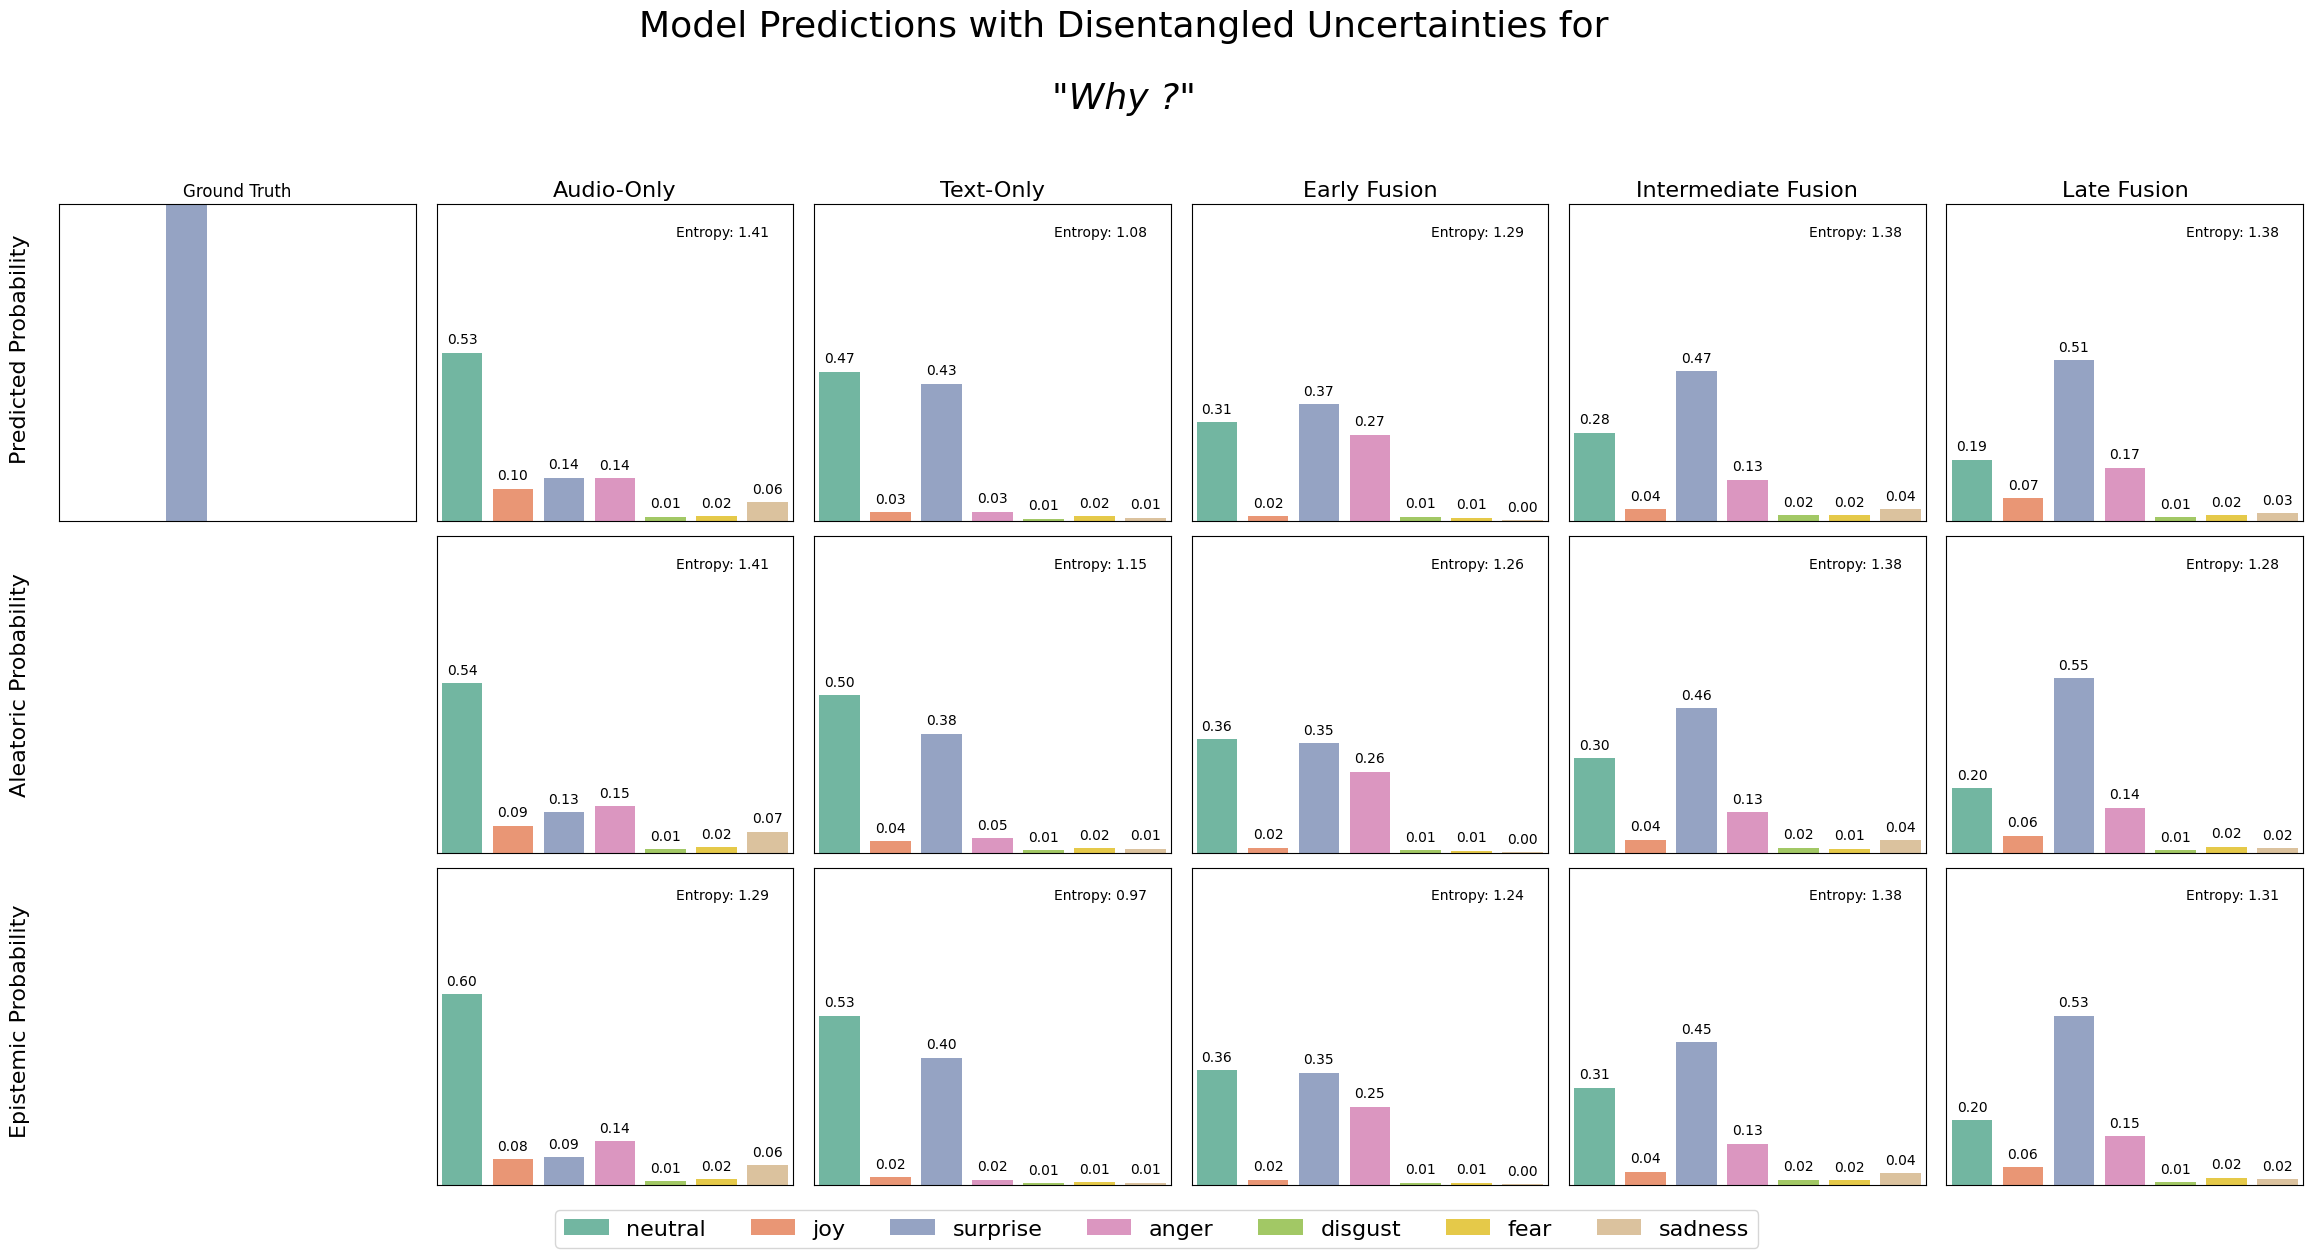

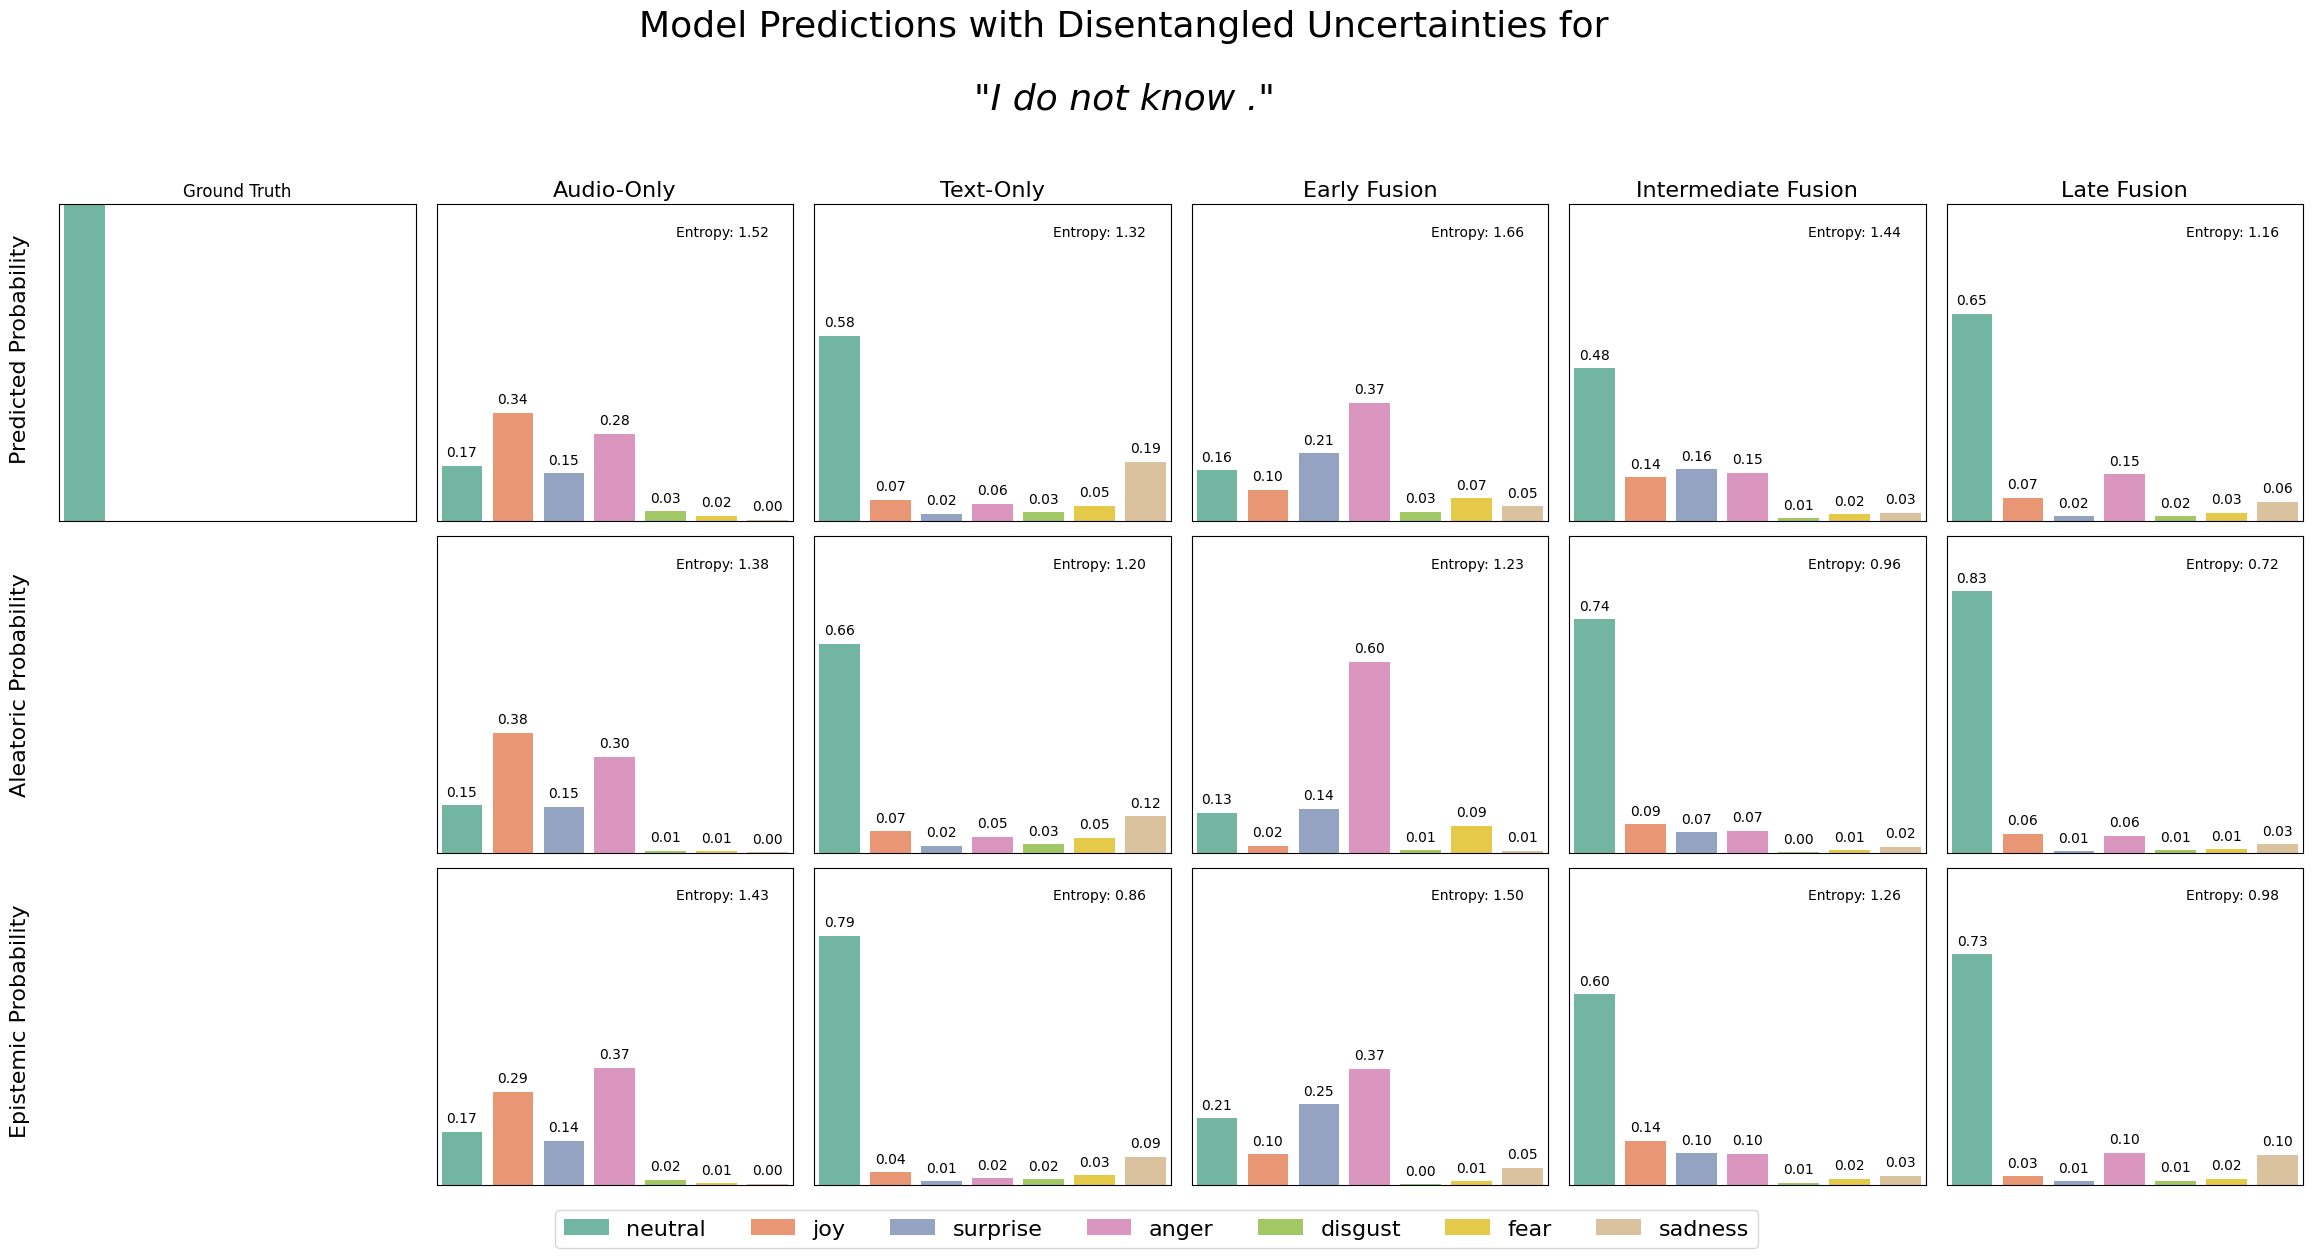

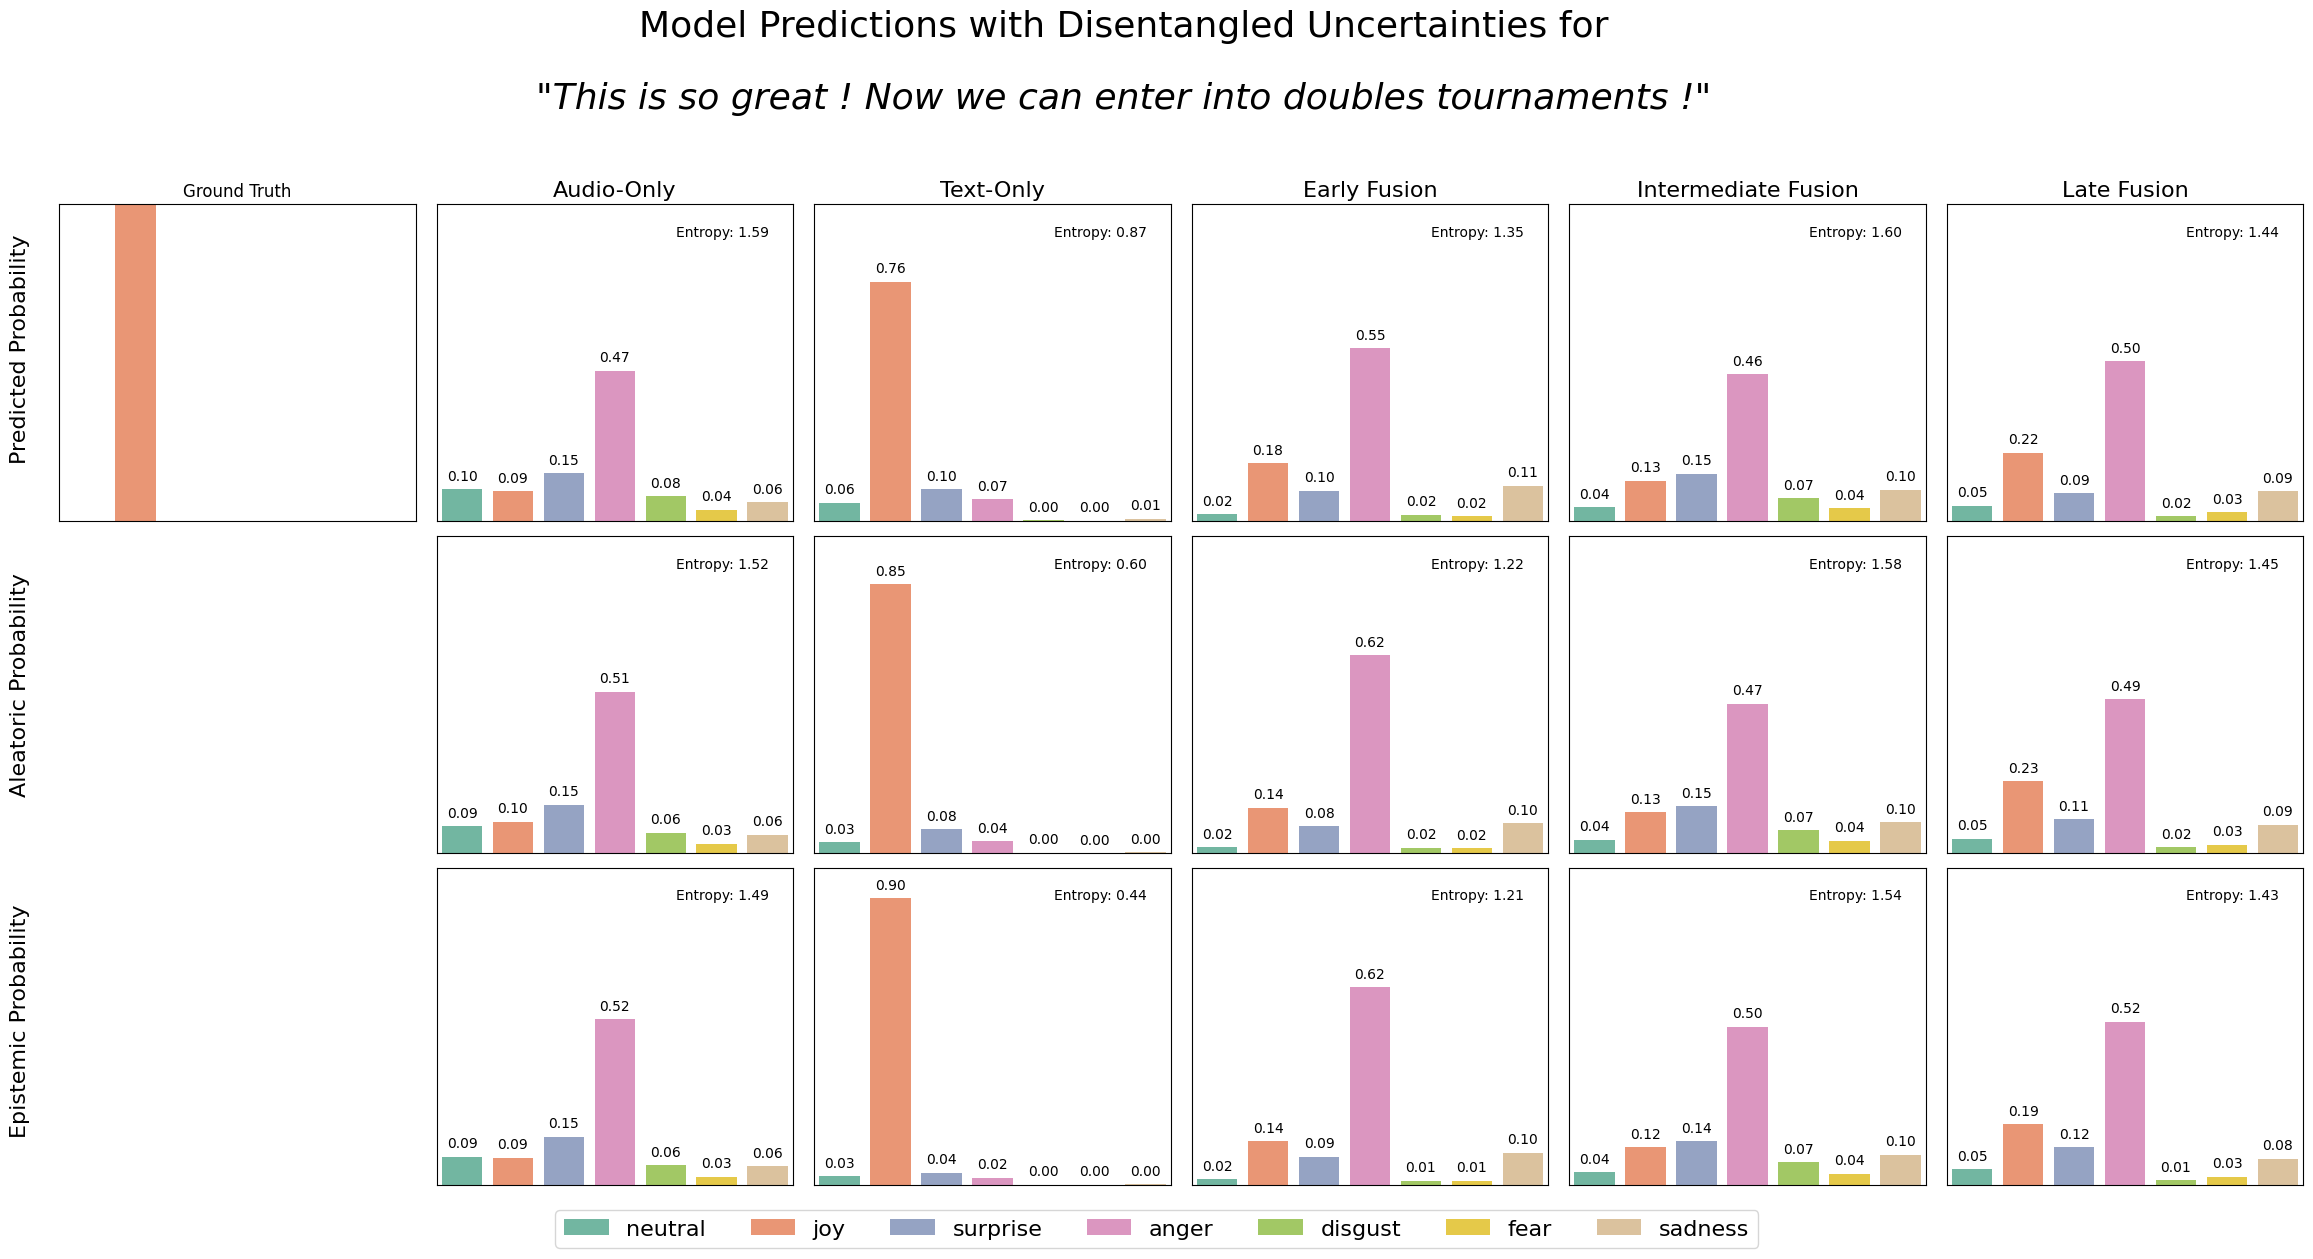

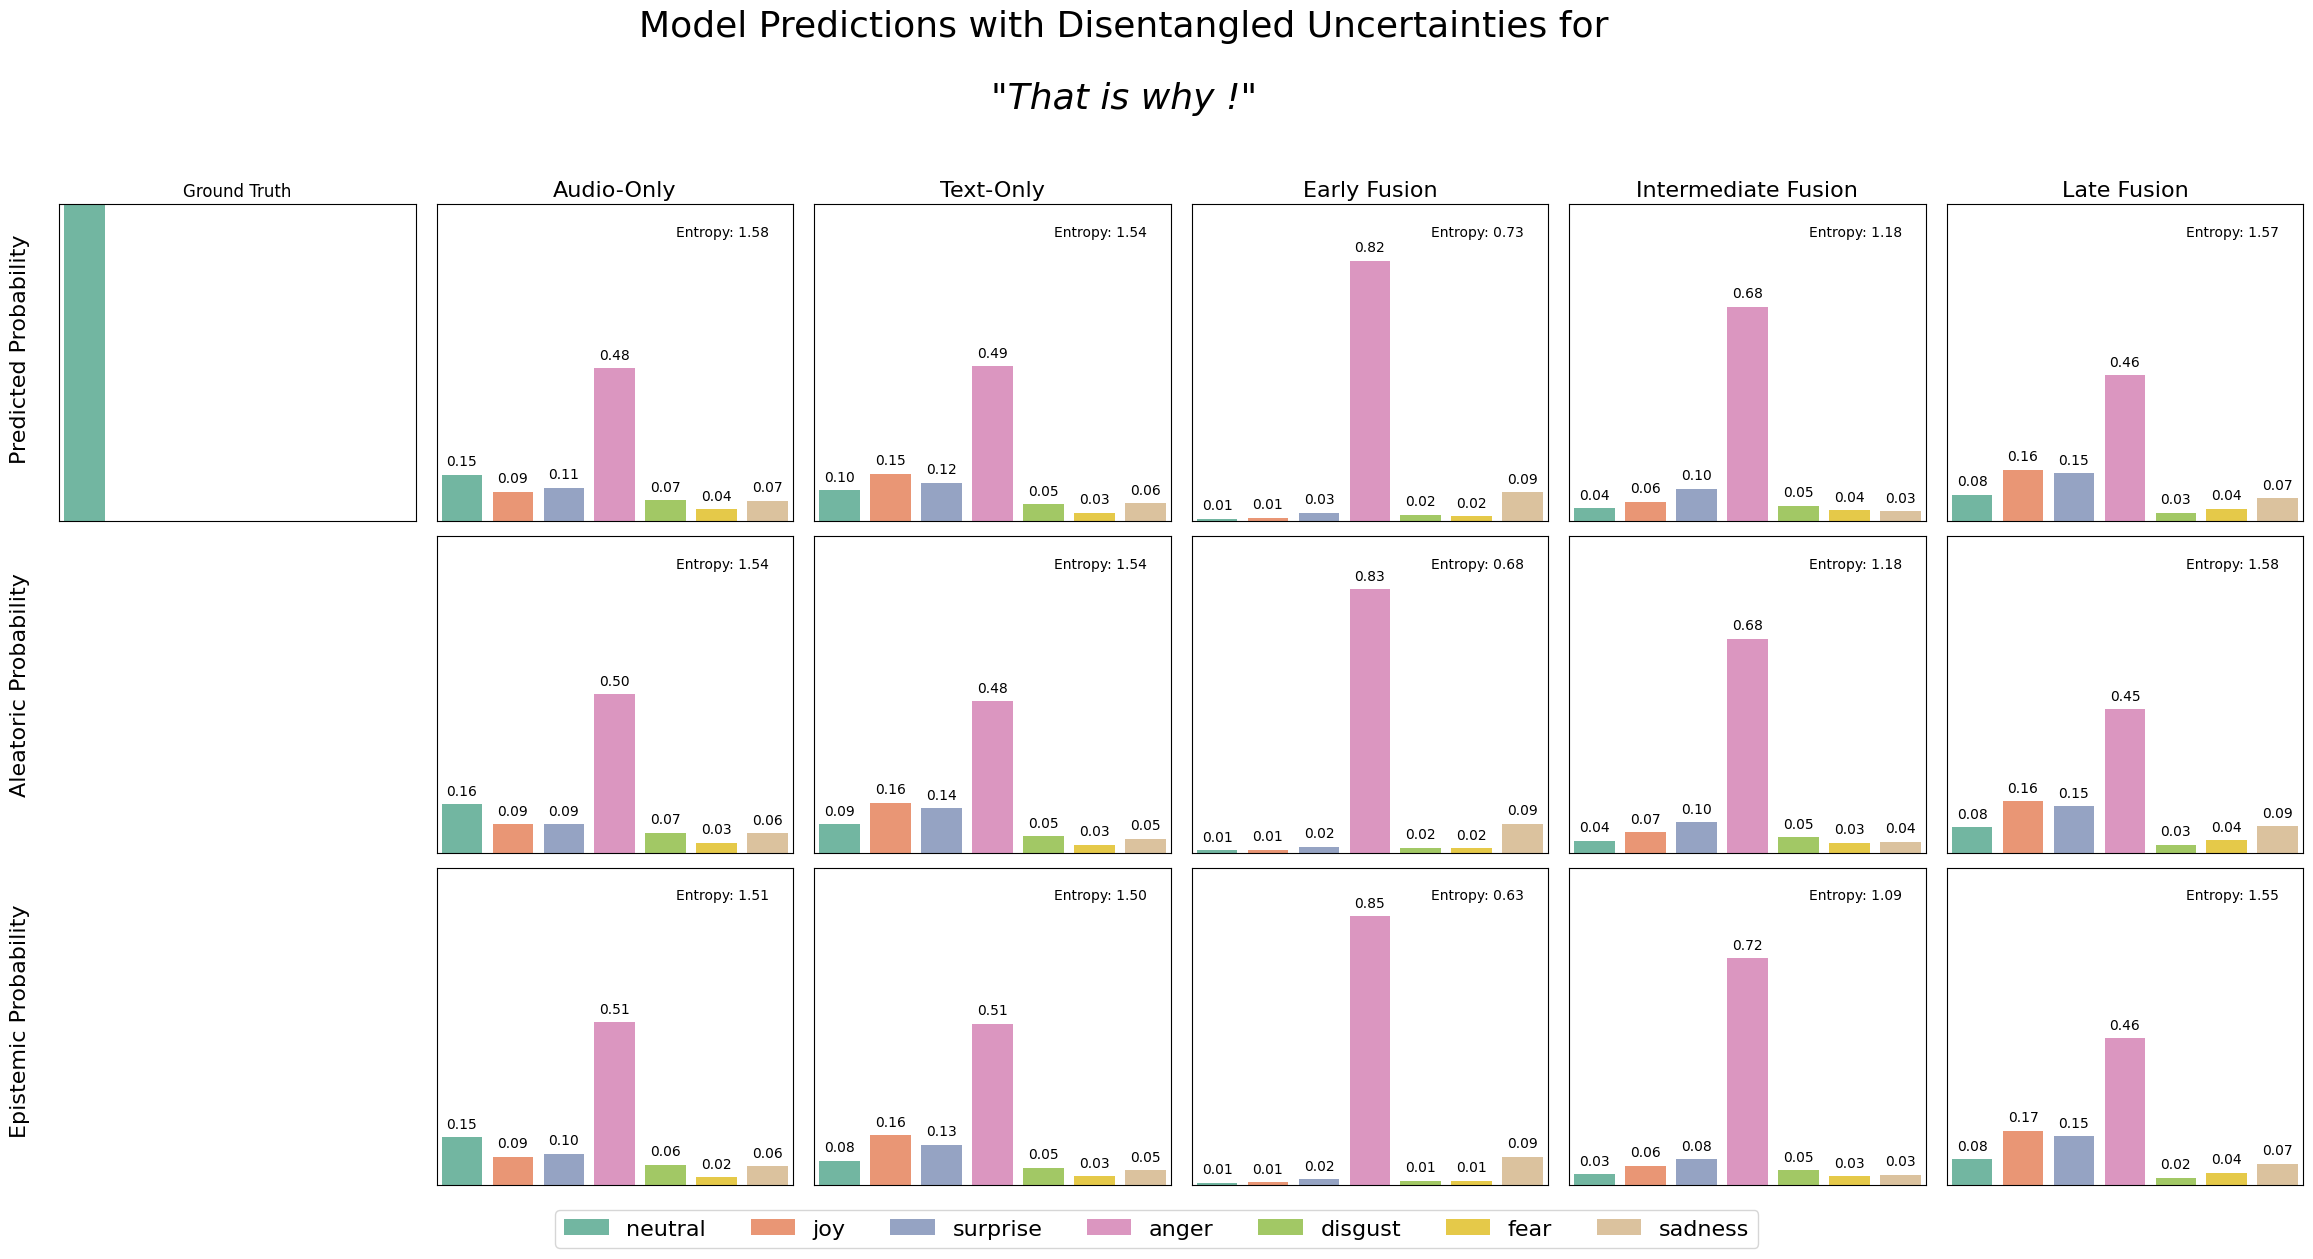

In [33]:
j = 0
for i in range(5):
    text = lines5.values.tolist()[i]
    print(f"Text:\t {text}\n")
    j += 1
    X_text = X_test_text[-1*(5-i)][None,]
    X_audio = X_test_audio[-1*(5-i)][None,]
    X_both = [X_test_both[0][-1*(5-i)][None,], X_test_both[1][-1*(5-i)][None,]]
    y_true = y_test_onehot[-1*(5-i)][None,]

    plot_probs_with_uncertainty(models, y_true, X_audio, X_text, X_both, text[0])